# Continuous Control

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the second project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.insert(1, 'scripts/')  # TODO: insert at 1, 0 is the script path (or '' in REPL)

from unityagents import UnityEnvironment
import numpy as np
import torch
from collections import deque
import shutil
import os
import matplotlib.pyplot as plt
%matplotlib inline

from d4pg_agent import D4PG_Agent
from params import Params
from logger import Logger

In [3]:
torch.autograd.set_detect_anomaly(True)

In [4]:
np.seterr(all='raise')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Reacher.app"`
- **Windows** (x86): `"path/to/Reacher_Windows_x86/Reacher.exe"`
- **Windows** (x86_64): `"path/to/Reacher_Windows_x86_64/Reacher.exe"`
- **Linux** (x86): `"path/to/Reacher_Linux/Reacher.x86"`
- **Linux** (x86_64): `"path/to/Reacher_Linux/Reacher.x86_64"`
- **Linux** (x86, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86"`
- **Linux** (x86_64, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86_64"`

For instance, if you are using a Mac, then you downloaded `Reacher.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Reacher.app")
```

In [5]:
env = UnityEnvironment(file_name='Crawler_Windows_x86_64/Crawler.exe')
# env = UnityEnvironment(file_name='Crawler_Windows_x86_64/Crawler.exe', no_graphics=True)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: CrawlerBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 129
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 20
        Vector Action descriptions: , , , , , , , , , , , , , , , , , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [6]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, a double-jointed arm can move to target locations. A reward of `+0.1` is provided for each step that the agent's hand is in the goal location. Thus, the goal of your agent is to maintain its position at the target location for as many time steps as possible.

The observation space consists of `33` variables corresponding to position, rotation, velocity, and angular velocities of the arm.  Each action is a vector with four numbers, corresponding to torque applicable to two joints.  Every entry in the action vector must be a number between `-1` and `1`.

Run the code cell below to print some information about the environment.

In [7]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 12
Size of each action: 20
There are 12 agents. Each observes a state with length: 129
The state for the first agent looks like: [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  2.25000000e+00
  1.00000000e+00  0.00000000e+00  1.78813934e-07  0.00000000e+00
  1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  6.06093168e-01 -1.42857209e-01 -6.06078804e-01  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  1.33339906e+00 -1.42857209e-01
 -1.33341408e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -6.0609

### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Once this cell is executed, you will watch the agent's performance, if it selects an action at random with each time step.  A window should pop up that allows you to observe the agent, as it moves through the environment.  

Of course, as part of the project, you'll have to change the code so that the agent is able to use its experience to gradually choose better actions when interacting with the environment!

In [6]:
# env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
# states = env_info.vector_observations                  # get the current state (for each agent)
# scores = np.zeros(num_agents)                          # initialize the score (for each agent)
# while True:
#     actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
#     actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
#     env_info = env.step(actions)[brain_name]           # send all actions to tne environment
#     next_states = env_info.vector_observations         # get next state (for each agent)
#     rewards = env_info.rewards                         # get reward (for each agent)
#     dones = env_info.local_done                        # see if episode finished
#     scores += env_info.rewards                         # update the score (for each agent)
#     states = next_states                               # roll over states to next time step
#     if np.any(dones):                                  # exit loop if episode finished
#         break
# print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

When finished, you can close the environment.

In [7]:
# env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

While training is taking place, statistics on agent performance are available from Tensorboard. To launch it use:
```python
cd <PROJECT_DIR>
tensorboard --logdir=runs
```

In [46]:
def d4pg(params=Params(), logger=Logger()):
    
    env_info = env.reset(train_mode=True)[brain_name]
    action_size = brain.vector_action_space_size
    state_size = env_info.vector_observations.shape[1]
    logger.initialize(agent, state_size, action_size)
    
    try:
    
        start_eps = params.eps_to_resume_from if not params.restart_training else 1        
        for i_episode in range(start_eps, params.n_episodes+1):
            env_info = env.reset(train_mode=True)[brain_name]  # reset the environment
            states = env_info.vector_observations              # get the current state
            agent.reset()
            score = np.zeros(len(env_info.agents))

            for t in range(params.max_t):                             

                # REPORT NAN STATES
                for i, state in enumerate(states):
                    has_NAN_in_state = np.isnan(state)
                    if any(has_NAN_in_state):
                        print("NaN State Found in Robot {}! Skipping episode..".format(i))
                        continue
                        
                
                # Perform actions from each agent's policy network (clipped actions [0, -1])
                actions = [ agent.act(state) for state in states ]  
                actions = np.stack(actions)            
                env_info = env.step(actions)[brain_name]      
                next_states, rewards, dones = env_info.vector_observations, env_info.rewards, env_info.local_done

                # REPORT NAN NEXT_STATES & ACTIONS
                for i, next_state in enumerate(next_states):
                    has_NAN_in_next_state = np.isnan(next_state)
                    if any(has_NAN_in_next_state):
                        print("NaN Next_State Found in Robot {}! Converting to 0".format(i))
                        print("BEFORE: ", next_state)
                        next_state = np.where(has_NAN_in_next_state, 0, next_state)
                        print("AFTER: ", next_state)
                        
                for i, action in enumerate(actions):
                    has_NAN_in_action = np.isnan(action)
                    if any(has_NAN_in_action):
                        print("NaN Action Found in Robot {}!".format(i))
                        print(action)
                
                # If rewards is super low / NaN for some reason, skip logging! (Prevent exploding gradients bug)
                low_rewards = np.array(rewards)<-50
                if any(low_rewards):                
                    mean_low_rewards = np.array(rewards)[low_rewards].mean()
                    print("Errorneously low Reward = {:.2f} Found! Doing nothing...".format(mean_low_rewards))
                    # rewards = np.where(low_rewards, 0, rewards)
#                     print("SKIPPING TRAINING OF THIS TIMESTEP")
#                     continue
                    
                has_NAN_in_rewards = np.isnan(rewards)
                if any(has_NAN_in_rewards):
                    # rewards = np.where(has_NAN_in_rewards, -0.1, rewards)
                    print("NaN Reward Found!.")
                    print("SKIPPING TRAINING OF THIS TIMESTEP")
                    continue

                # Allow crawler to keep resetting if fall, but reset score to 0 if so
                agent.step(states, actions, rewards, next_states, dones, clear_nstep_buffer=(t==0))
                states = next_states
                score += np.array(rewards)
                score = np.where(dones, 0, score)
                # score += (sum(rewards) / len(rewards))  # ALT METRIC: Max

                # Break if any of the agent is done
                if all(dones):   # any()
                    break 

    #         # If score is super low for some reason, cap!
    #         low_score = np.array(score)<-100
    #         if any(low_score):
    #             rewards = np.where(np.array(low_score)<-100, 0, score)
    #             print("Super low Reward Found! Converting to R=0 instead...")
    #             print("CORRECTED-LOW REWARDS: ", rewards)

            # Print crucial results for progress tracking
            if agent.memory_buffer_prefilled():

                logger.log_stats(i_episode, float(score.mean()), agent.actor_loss, agent.critic_loss)
                print('\rEpisode {}\ Score: {:.2f}'.format(i_episode, logger.scores_deque[-1]), end="")

                if i_episode % params.save_every == 0:
                    logger.save_weights(i_episode)

                if i_episode % params.print_every == 0:
                    print('\rEpisode {}: \tActor Loss: {:.2f} \tCritic Loss: {:.2f} \n\t\tAverage Score: {:.2f}\n'
                          .format(i_episode, np.mean(logger.actor_loss_deque), np.mean(logger.critic_loss_deque), np.mean(logger.scores_deque)))
                    print('REWARDS (this eps): ', score, '\n')
                    
                    if np.mean(logger.scores_deque) >= params.target_score:
                        print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'
                              .format(i_episode, np.mean(logger.scores_deque)))
                        if params.terminate_on_target_score:
                            break
                            
        # Plot graphs & save final weights
        logger.save_weights(i_episode)
        if params.plot_stats:
            logger.plot_stats()
        logger.log_overall_perf_tb()

    # Catch any exceptions (Esp with keyboard interrupts)
    except BaseException as error:
        print('\n\n==== An exception occurred: {}'.format(error))
        logger.print_weights()
        logger.save_weights(i_episode)
        if params.plot_stats:
            logger.plot_stats()
        logger.log_overall_perf_tb()
    
    return logger.scores_list

In [47]:
##################
# QUICK TEST
##################

# Params Override: Initialized in params.py
params = Params()
params.verbose = True
params.random_seed = 0
params.n_episodes=3
params.max_t = 100
params.print_every = 100
params.save_every = 100
params.prefill_memory_qty=0
params.terminate_on_target_score = True
params.plot_stats = True
params.lr_actor = 5e-4                  
params.lr_critic = 1e-3  
params.vmin = -20
params.vmax = 20


#### MAIN #####
logger = Logger(params)
agent = D4PG_Agent(state_size, action_size, params=params)
d4pg(params, logger)


=============== NETWORKS ===============
actor_local Actor(
  (bn0): BatchNorm1d(129, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=129, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=128, out_features=20, bias=True)
)
actor_target Actor(
  (bn0): BatchNorm1d(129, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=129, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=128, out_features=20, bias=True)
)
criti

KeyboardInterrupt: 

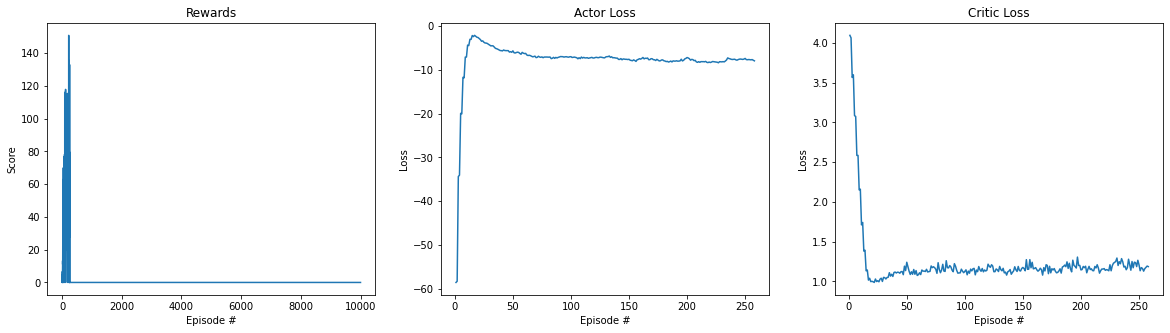

In [105]:
def plot_graph(logger):
    
    score_arr  = np.array(logger.scores_list)
    score_arr[score_arr < 0] = 0
    _, axs = plt.subplots(1, 3, figsize=(20, 5))

    # Scores
    axs[0].plot(np.arange(1, len(logger.scores_list)+1), score_arr)
    axs[0].set(xlabel='Episode #', ylabel='Score')
    axs[0].set_title('Rewards')
        
    # Actor Loss
    axs[1].plot(np.arange(1, len(logger.actor_loss_list)+1), logger.actor_loss_list)
    axs[1].set(xlabel='Episode #', ylabel='Loss')
    axs[1].set_title('Actor Loss')
    
    # Critic Loss
    axs[2].plot(np.arange(1, len(logger.critic_loss_list)+1), logger.critic_loss_list)
    axs[2].set(xlabel='Episode #', ylabel='Loss')
    axs[2].set_title('Critic Loss')
    plt.show()
    
plot_graph(logger)

In [ ]:
####################### 
# Increasing Hard Update rates C & buffer size
#######################


##################
# Params Override: Initialized in params.py
params = Params()
params.random_seed = 0
params.n_episodes=5000
params.max_t = 3000
params.print_every = 100
params.save_every = 100
params.prefill_memory_qty=5000
params.terminate_on_target_score = True
params.plot_stats = True
params.lr_actor = 5e-4                  
params.lr_critic = 1e-3 
params.vmin = 0
params.vmax = 200   
params.num_atoms = 100
params.hard_weights_update_every = 1000
params.buffer_size = int(1e6)

#### MAIN #####
logger = Logger(params)
agent = D4PG_Agent(state_size, action_size, params=params)
d4pg(params, logger)


##################
# Params Override: Initialized in params.py
params = Params()
params.random_seed = 0
params.n_episodes=5000
params.max_t = 3000
params.print_every = 100
params.save_every = 100
params.prefill_memory_qty=5000
params.terminate_on_target_score = True
params.plot_stats = True
params.lr_actor = 1e-4                  
params.lr_critic = 1e-3 
params.vmin = 0
params.vmax = 200   
params.num_atoms = 100
params.hard_weights_update_every = 2000
params.buffer_size = int(1e6)

#### MAIN #####
logger = Logger(params)
agent = D4PG_Agent(state_size, action_size, params=params)
d4pg(params, logger)


##################
# Params Override: Initialized in params.py
params = Params()
params.random_seed = 0
params.n_episodes=5000
params.max_t = 3000
params.print_every = 100
params.save_every = 100
params.prefill_memory_qty=5000
params.terminate_on_target_score = True
params.plot_stats = True
params.lr_actor = 1e-4                  
params.lr_critic = 1e-3 
params.vmin = 0
params.vmax = 200   
params.num_atoms = 100
params.hard_weights_update_every = 3000
params.buffer_size = int(1e6)

#### MAIN #####
logger = Logger(params)
agent = D4PG_Agent(state_size, action_size, params=params)
d4pg(params, logger)


=============== HYPERPARAMS ===============
DEVICE:  cuda:0
RANDOM SEED:  0
BUFFER_SIZE:  1000000
BATCH_SIZE:  512
GAMMA:  0.9
TAU:  0.001
LR_ACTOR:  5e-05
LR_CRITIC:  0.0001
WEIGHT_DECAY:  0.0001
HARD_UPDATE:  True
LEARN_EVERY:  1
HARD_WEIGHTS_UPDATE_EVERY:  2000
N_STEP_BOOTSTRAP:  5
VMIN:  -1
VMAX:  200
NUM_ATOMS:  100

Prefilling Replay Memory Buffer: 5004 / 5000
 ===== Replay Buffer prefilled. Agent will begin learning. =====

Episode 100: 	Actor Loss: -4.72 	Critic Loss: 1.17 
		Average Score: 15.23

Episode 200: 	Actor Loss: -5.55 	Critic Loss: 1.08 
		Average Score: 31.42



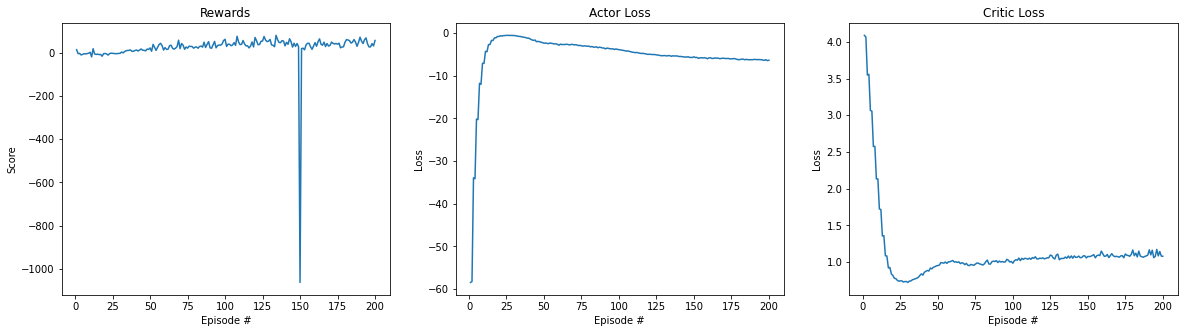


=============== HYPERPARAMS ===============
DEVICE:  cuda:0
RANDOM SEED:  0
BUFFER_SIZE:  1000000
BATCH_SIZE:  512
GAMMA:  0.9
TAU:  0.001
LR_ACTOR:  5e-05
LR_CRITIC:  5e-05
WEIGHT_DECAY:  0.0001
HARD_UPDATE:  True
LEARN_EVERY:  1
HARD_WEIGHTS_UPDATE_EVERY:  2000
N_STEP_BOOTSTRAP:  5
VMIN:  -1
VMAX:  200
NUM_ATOMS:  100

Prefilling Replay Memory Buffer: 5004 / 5000
 ===== Replay Buffer prefilled. Agent will begin learning. =====

Episode 100: 	Actor Loss: -3.43 	Critic Loss: 1.04 
		Average Score: 2.42

Episode 200: 	Actor Loss: -3.76 	Critic Loss: 0.99 
		Average Score: 16.55



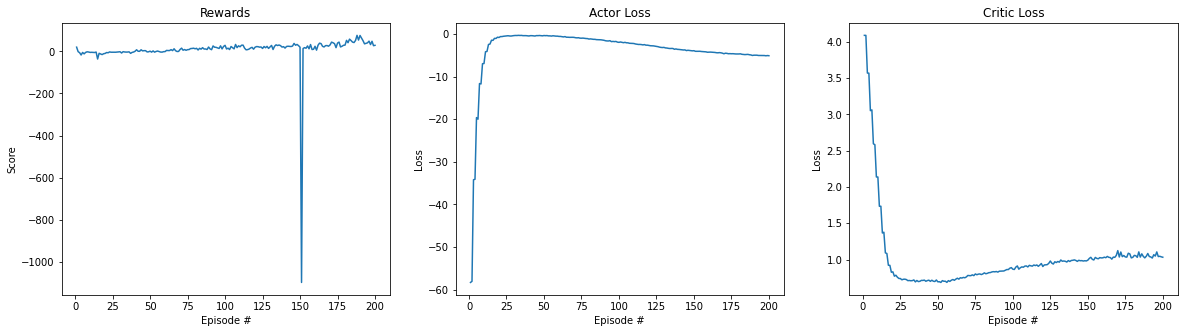


=============== HYPERPARAMS ===============
DEVICE:  cuda:0
RANDOM SEED:  0
BUFFER_SIZE:  1000000
BATCH_SIZE:  512
GAMMA:  0.9
TAU:  0.001
LR_ACTOR:  1e-05
LR_CRITIC:  5e-05
WEIGHT_DECAY:  0.0001
HARD_UPDATE:  True
LEARN_EVERY:  1
HARD_WEIGHTS_UPDATE_EVERY:  2000
N_STEP_BOOTSTRAP:  5
VMIN:  -1
VMAX:  200
NUM_ATOMS:  100

Prefilling Replay Memory Buffer: 5004 / 5000
 ===== Replay Buffer prefilled. Agent will begin learning. =====

Episode 19\ Score: 22.05NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Conver

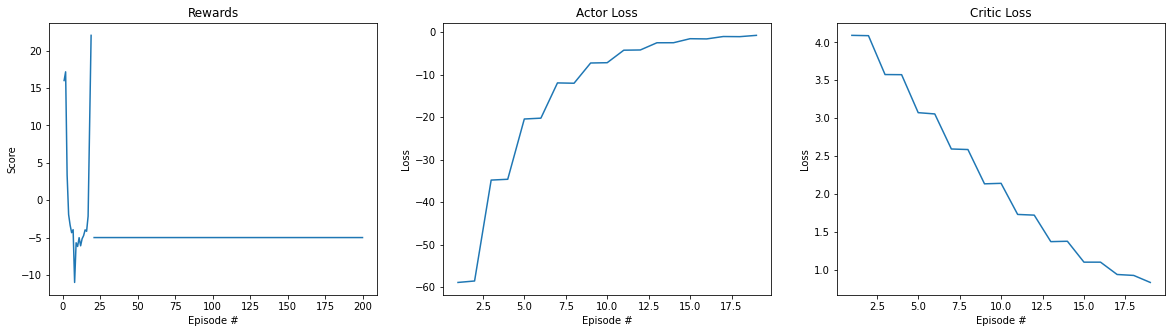

[16.004861294322836,
 17.169842965640175,
 3.3620741892357007,
 -1.9227765432992279,
 -3.335259335911058,
 -4.344993908854829,
 -3.947141599978043,
 -11.00369619594615,
 -5.698460225727307,
 -6.190930830269483,
 -5.013788565016713,
 -6.1007357562743385,
 -5.158827243482746,
 -4.7378689331235355,
 -3.9675092095308675,
 -4.158895326357095,
 -2.139143584869292,
 9.661191419427874,
 22.046775577544196,
 nan,
 -5.0,
 -5.0,
 -5.0,
 -5.0,
 -5.0,
 -5.0,
 -5.0,
 -5.0,
 -5.0,
 -5.0,
 -5.0,
 -5.0,
 -5.0,
 -5.0,
 -5.0,
 -5.0,
 -5.0,
 -5.0,
 -5.0,
 -5.0,
 -5.0,
 -5.0,
 -5.0,
 -5.0,
 -5.0,
 -5.0,
 -5.0,
 -5.0,
 -5.0,
 -5.0,
 -5.0,
 -5.0,
 -5.0,
 -5.0,
 -5.0,
 -5.0,
 -5.0,
 -5.0,
 -5.0,
 -5.0,
 -5.0,
 -5.0,
 -5.0,
 -5.0,
 -5.0,
 -5.0,
 -5.0,
 -5.0,
 -5.0,
 -5.0,
 -5.0,
 -5.0,
 -5.0,
 -5.0,
 -5.0,
 -5.0,
 -5.0,
 -5.0,
 -5.0,
 -5.0,
 -5.0,
 -5.0,
 -5.0,
 -5.0,
 -5.0,
 -5.0,
 -5.0,
 -5.0,
 -5.0,
 -5.0,
 -5.0,
 -5.0,
 -5.0,
 -5.0,
 -5.0,
 -5.0,
 -5.0,
 -5.0,
 -5.0,
 -5.0,
 -5.0,
 -5.0,
 -5.0,
 -5.0,
 -5.

In [12]:
#####
# TRYING OUT THE Learning Rates
#####

##################
# Params Override: Initialized in params.py
params = Params()
params.random_seed = 0
params.n_episodes=200
params.max_t = 1000
params.print_every = 100
params.save_every = 100
params.prefill_memory_qty=5000
params.terminate_on_target_score = True
params.plot_stats = True
params.lr_actor = 5e-5                  
params.lr_critic = 1e-4 
params.vmin = -1
params.vmax = 200
params.num_atoms = 100
params.hard_weights_update_every = 2000
params.buffer_size = int(1e6)
params.gamma = 0.9
params.batch_size = 512

#### MAIN #####
logger = Logger(params)
agent = D4PG_Agent(state_size, action_size, params=params)
d4pg(params, logger)

##################
# Params Override: Initialized in params.py
params = Params()
params.random_seed = 0
params.n_episodes=200
params.max_t = 1000
params.print_every = 100
params.save_every = 100
params.prefill_memory_qty=5000
params.terminate_on_target_score = True
params.plot_stats = True
params.lr_actor = 5e-5                  
params.lr_critic = 5e-5 
params.vmin = -1
params.vmax = 200
params.num_atoms = 100
params.hard_weights_update_every = 2000
params.buffer_size = int(1e6)
params.gamma = 0.9
params.batch_size = 512

#### MAIN #####
logger = Logger(params)
agent = D4PG_Agent(state_size, action_size, params=params)
d4pg(params, logger)

##################
# Params Override: Initialized in params.py
params = Params()
params.random_seed = 0
params.n_episodes=200
params.max_t = 1000
params.print_every = 100
params.save_every = 100
params.prefill_memory_qty=5000
params.terminate_on_target_score = True
params.plot_stats = True
params.lr_actor = 1e-5                  
params.lr_critic = 5e-5 
params.vmin = -1
params.vmax = 200
params.num_atoms = 100
params.hard_weights_update_every = 2000
params.buffer_size = int(1e6)
params.gamma = 0.9
params.batch_size = 512

#### MAIN #####
logger = Logger(params)
agent = D4PG_Agent(state_size, action_size, params=params)
d4pg(params, logger)

In [9]:
#######################
# SEEMS TO WORK WELL SO FAR... (+130 rewards)
#######################

##################
# Params Override: Initialized in params.py
params = Params()
params.random_seed = 0
params.n_episodes=1000
params.max_t = 1000
params.print_every = 100
params.save_every = 100
params.prefill_memory_qty=10000
params.terminate_on_target_score = True
params.plot_stats = True
params.lr_actor = 1e-5                  
params.lr_critic = 1e-4 
params.vmin = -1
params.vmax = 200
params.num_atoms = 100
params.hard_weights_update_every = 2000
params.buffer_size = int(1e6)
params.gamma = 0.95
params.batch_size = 2048

#### MAIN #####
logger = Logger(params)
agent = D4PG_Agent(state_size, action_size, params=params)
d4pg(params, logger)


=============== HYPERPARAMS ===============
DEVICE:  cuda:0
RANDOM SEED:  0
BUFFER_SIZE:  1000000
BATCH_SIZE:  2048
GAMMA:  0.95
TAU:  0.001
LR_ACTOR:  1e-05
LR_CRITIC:  0.0001
WEIGHT_DECAY:  0.0001
HARD_UPDATE:  True
LEARN_EVERY:  1
HARD_WEIGHTS_UPDATE_EVERY:  2000
N_STEP_BOOTSTRAP:  5
VMIN:  -1
VMAX:  200
NUM_ATOMS:  100

Prefilling Replay Memory Buffer: 10008 / 10000
 ===== Replay Buffer prefilled. Agent will begin learning. =====

Episode 100: 	Actor Loss: -11.96 	Critic Loss: 1.98 
		Average Score: 21.48

Episode 127\ Score: 131.2479

ERROR:root:Exception calling application: pickle data was truncated
Traceback (most recent call last):
  File "C:\Users\derek\anaconda3\envs\drlnd_gpu\lib\site-packages\grpc\_server.py", line 385, in _call_behavior
    return behavior(argument, context), True
  File "C:\Users\derek\anaconda3\envs\drlnd_gpu\lib\site-packages\unityagents\rpc_communicator.py", line 26, in Exchange
    return self.child_conn.recv()
  File "C:\Users\derek\anaconda3\envs\drlnd_gpu\lib\multiprocessing\connection.py", line 251, in recv
    return _ForkingPickler.loads(buf.getbuffer())
_pickle.UnpicklingError: pickle data was truncated
ERROR:root:Exception calling application: 
Traceback (most recent call last):
  File "C:\Users\derek\anaconda3\envs\drlnd_gpu\lib\site-packages\grpc\_server.py", line 385, in _call_behavior
    return behavior(argument, context), True
  File "C:\Users\derek\anaconda3\envs\drlnd_gpu\lib\site-packages\unityagents\rpc_communicator.py", line 26, in Exchange
    return self.child_conn

KeyError: 'CrawlerBrain'

In [30]:
#######################
# SPEEDING THINGS UP
#######################

##################
# Achieved ~=+150 score
##################
# Params Override: Initialized in params.py
params = Params()
params.random_seed = 0
params.n_episodes=1000
params.max_t = 1000
params.print_every = 100
params.save_every = 100
params.prefill_memory_qty=10000
params.terminate_on_target_score = True
params.plot_stats = True
params.lr_actor = 1e-5                  
params.lr_critic = 1e-4 
params.vmin = -1
params.vmax = 200
params.num_atoms = 100
params.hard_weights_update_every = 2000
params.buffer_size = int(1e6)
params.gamma = 0.95
params.batch_size = 2048

#### MAIN #####
logger = Logger(params)
agent = D4PG_Agent(state_size, action_size, params=params)
d4pg(params, logger)

# #####
# # REWARDS GETS NAN AT 130 EPOCHS
# ##################
# # Params Override: Initialized in params.py
# params = Params()
# params.random_seed = 0
# params.n_episodes=1000
# params.max_t = 1000
# params.print_every = 100
# params.save_every = 100
# params.prefill_memory_qty=100
# params.terminate_on_target_score = True
# params.plot_stats = True
# params.lr_actor = 1e-5                  
# params.lr_critic = 1e-4 
# params.vmin = -1
# params.vmax = 200
# params.num_atoms = 100
# params.hard_weights_update_every = 2000
# params.buffer_size = int(1e6)
# params.gamma = 0.95
# params.batch_size = 512

# #### MAIN #####
# logger = Logger(params)
# agent = D4PG_Agent(state_size, action_size, params=params)
# d4pg(params, logger)


=============== HYPERPARAMS ===============
DEVICE:  cuda:0
RANDOM SEED:  0
BUFFER_SIZE:  1000000
BATCH_SIZE:  2048
GAMMA:  0.95
TAU:  0.001
LR_ACTOR:  1e-05
LR_CRITIC:  0.0001
WEIGHT_DECAY:  0.0001
HARD_UPDATE:  True
LEARN_EVERY:  1
HARD_WEIGHTS_UPDATE_EVERY:  2000
N_STEP_BOOTSTRAP:  5
VMIN:  -1
VMAX:  200
NUM_ATOMS:  100

Prefilling Replay Memory Buffer: 10008 / 10000
 ===== Replay Buffer prefilled. Agent will begin learning. =====

Episode 88\ Score: 155.47NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! 

NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Fo

NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Fo

KeyboardInterrupt: 

In [15]:
#################
#EXPERIMENTING WITH VMAX
#################

##################
# Params Override: Initialized in params.py
params = Params()
params.random_seed = 0
params.n_episodes=1000
params.max_t = 1000
params.print_every = 100
params.save_every = 100
params.prefill_memory_qty=10000
params.terminate_on_target_score = True
params.plot_stats = True
params.lr_actor = 1e-5                  
params.lr_critic = 1e-4 
params.vmin = -1
params.vmax = 2000
params.num_atoms = 100
params.hard_weights_update_every = 2000
params.buffer_size = int(1e6)
params.gamma = 0.95
params.batch_size = 512

#### MAIN #####
logger = Logger(params)
agent = D4PG_Agent(state_size, action_size, params=params)
d4pg(params, logger)


=============== HYPERPARAMS ===============
DEVICE:  cuda:0
RANDOM SEED:  0
BUFFER_SIZE:  1000000
BATCH_SIZE:  512
HIDDEN_SIZES:  (256, 128)
GAMMA:  0.95
TAU:  0.001
LR_ACTOR:  1e-05
LR_CRITIC:  0.0001
WEIGHT_DECAY:  0.0001
HARD_UPDATE:  True
LEARN_EVERY:  1
HARD_WEIGHTS_UPDATE_EVERY:  2000
N_STEP_BOOTSTRAP:  5
VMIN:  -1
VMAX:  2000
NUM_ATOMS:  100

Prefilling Replay Memory Buffer: 10008 / 10000
 ===== Replay Buffer prefilled. Agent will begin learning. =====

Episode 100: 	Actor Loss: -70.68 	Critic Loss: 1.22 
		Average Score: 16.02

Episode 200: 	Actor Loss: -11.19 	Critic Loss: 0.66 
		Average Score: 16.24

Episode 203\ Score: 34.38

KeyboardInterrupt: 


=============== HYPERPARAMS ===============
DEVICE:  cuda:0
RANDOM SEED:  0
BUFFER_SIZE:  1000000
BATCH_SIZE:  512
HIDDEN_SIZES:  (256, 128)
GAMMA:  0.95
TAU:  0.001
LR_ACTOR:  1e-05
LR_CRITIC:  0.0001
WEIGHT_DECAY:  0.0001
HARD_UPDATE:  True
LEARN_EVERY:  1
HARD_WEIGHTS_UPDATE_EVERY:  2000
N_STEP_BOOTSTRAP:  5
VMIN:  -1
VMAX:  400
NUM_ATOMS:  100

Prefilling Replay Memory Buffer: 10008 / 10000
 ===== Replay Buffer prefilled. Agent will begin learning. =====

Episode 100: 	Actor Loss: -16.26 	Critic Loss: 1.55 
		Average Score: 20.83

Episode 200: 	Actor Loss: -10.93 	Critic Loss: 1.24 
		Average Score: 81.62

Episode 300: 	Actor Loss: -16.14 	Critic Loss: 1.34 
		Average Score: 200.95



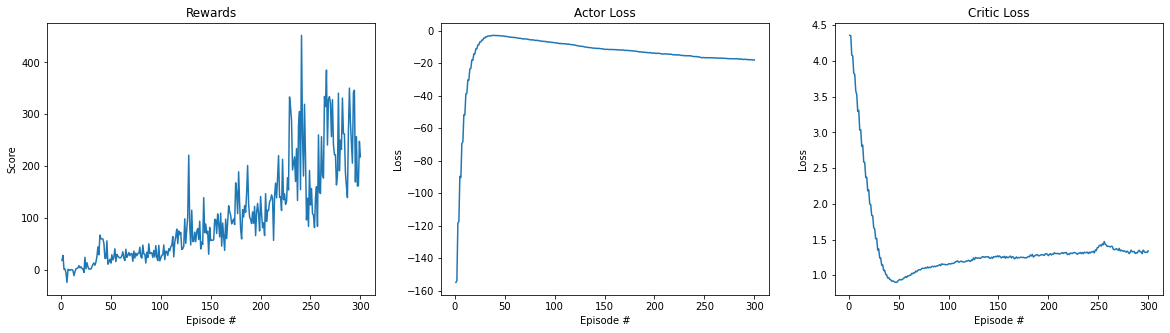


=============== HYPERPARAMS ===============
DEVICE:  cuda:0
RANDOM SEED:  0
BUFFER_SIZE:  1000000
BATCH_SIZE:  512
HIDDEN_SIZES:  (256, 128)
GAMMA:  0.95
TAU:  0.001
LR_ACTOR:  1e-05
LR_CRITIC:  0.0001
WEIGHT_DECAY:  0.0001
HARD_UPDATE:  True
LEARN_EVERY:  1
HARD_WEIGHTS_UPDATE_EVERY:  2000
N_STEP_BOOTSTRAP:  5
VMIN:  -1
VMAX:  100
NUM_ATOMS:  100

Prefilling Replay Memory Buffer: 10008 / 10000
 ===== Replay Buffer prefilled. Agent will begin learning. =====

Episode 100: 	Actor Loss: -7.40 	Critic Loss: 2.30 
		Average Score: 9.43

Episode 174\ Score: 33.43.67NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Rewar

ValueError: The histogram is empty, please file a bug report.

In [16]:
##################
# Achieved rewards @ eps~=400 in 300 episodes
##################
# Params Override: Initialized in params.py
params = Params()
params.random_seed = 0
params.n_episodes=300
params.max_t = 1000
params.print_every = 100
params.save_every = 100
params.prefill_memory_qty=10000
params.terminate_on_target_score = True
params.plot_stats = True
params.lr_actor = 1e-5                  
params.lr_critic = 1e-4 
params.vmin = -1
params.vmax = 400
params.num_atoms = 100
params.hard_weights_update_every = 2000
params.buffer_size = int(1e6)
params.gamma = 0.95
params.batch_size = 512

#### MAIN #####
logger = Logger(params)
agent = D4PG_Agent(state_size, action_size, params=params)
d4pg(params, logger)


##################
# NaN rewards @ eps~=100
##################
# Params Override: Initialized in params.py
params = Params()
params.random_seed = 0
params.n_episodes=300
params.max_t = 1000
params.print_every = 100
params.save_every = 100
params.prefill_memory_qty=10000
params.terminate_on_target_score = True
params.plot_stats = True
params.lr_actor = 1e-5                  
params.lr_critic = 1e-4 
params.vmin = -1
params.vmax = 100
params.num_atoms = 100
params.hard_weights_update_every = 2000
params.buffer_size = int(1e6)
params.gamma = 0.95
params.batch_size = 512

#### MAIN #####
logger = Logger(params)
agent = D4PG_Agent(state_size, action_size, params=params)
d4pg(params, logger)

In [19]:
##################

##################
# Params Override: Initialized in params.py
params = Params()
params.random_seed = 0
params.n_episodes=300
params.max_t = 1000
params.print_every = 100
params.save_every = 100
params.prefill_memory_qty=10000
params.terminate_on_target_score = True
params.plot_stats = True
params.lr_actor = 1e-5                  
params.lr_critic = 1e-4 
params.vmin = -1
params.vmax = 600
params.num_atoms = 100
params.hard_weights_update_every = 2000
params.buffer_size = int(1e6)
params.gamma = 0.95
params.batch_size = 512

#### MAIN #####
logger = Logger(params)
agent = D4PG_Agent(state_size, action_size, params=params)
d4pg(params, logger)





=============== HYPERPARAMS ===============
DEVICE:  cuda:0
RANDOM SEED:  0
BUFFER_SIZE:  1000000
BATCH_SIZE:  512
HIDDEN_SIZES:  (256, 128)
GAMMA:  0.95
TAU:  0.001
LR_ACTOR:  1e-05
LR_CRITIC:  0.0001
WEIGHT_DECAY:  0.0001
HARD_UPDATE:  True
LEARN_EVERY:  1
HARD_WEIGHTS_UPDATE_EVERY:  2000
N_STEP_BOOTSTRAP:  5
VMIN:  -1
VMAX:  600
NUM_ATOMS:  100

Prefilling Replay Memory Buffer: 10008 / 10000
 ===== Replay Buffer prefilled. Agent will begin learning. =====

Episode 55\ Score: 32.11NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 inste

NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Fo

NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Fo

NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Fo

NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Fo

ValueError: The histogram is empty, please file a bug report.

In [ ]:
##################
# Achieved rewards @ eps~=400 in 300 episodes
##################
# Params Override: Initialized in params.py
params = Params()
params.random_seed = 0
params.n_episodes=3000
params.max_t = 1000
params.print_every = 100
params.save_every = 100
params.prefill_memory_qty=10000
params.terminate_on_target_score = True
params.plot_stats = True
params.lr_actor = 1e-5                  
params.lr_critic = 1e-4 
params.vmin = -1
params.vmax = 400
params.num_atoms = 100
params.hard_weights_update_every = 2000
params.buffer_size = int(1e6)
params.gamma = 0.95
params.batch_size = 512

#### MAIN #####
logger = Logger(params)
agent = D4PG_Agent(state_size, action_size, params=params)
d4pg(params, logger)

# Resuming training from previous weights...


=============== HYPERPARAMS ===============
DEVICE:  cuda:0
RANDOM SEED:  0
BUFFER_SIZE:  1000000
BATCH_SIZE:  512
HIDDEN_SIZES:  (256, 128)
GAMMA:  0.95
TAU:  0.001
LR_ACTOR:  1e-05
LR_CRITIC:  0.0001
WEIGHT_DECAY:  0.0001
HARD_UPDATE:  True
LEARN_EVERY:  1
HARD_WEIGHTS_UPDATE_EVERY:  2000
N_STEP_BOOTSTRAP:  5
VMIN:  -1
VMAX:  400
NUM_ATOMS:  100

Prefilling Replay Memory Buffer: 100008 / 100000
 ===== Replay Buffer prefilled. Agent will begin learning. =====

Episode 280: 	Actor Loss: -14.97 	Critic Loss: 1.36 
		Average Score: 42.34

REWARDS (this eps):  [  2.57530135  14.97456701  68.82201805   4.22913162  61.97223257
  92.00411245  11.8618752   64.27226669 139.81297885  18.23499936
 145.28537151 282.28194567] 

Episode 300: 	Actor Loss: -15.54 	Critic Loss: 1.37 
		Average Score: 22.58

REWARDS (this eps):  [109.53259972  27.72984661  75.54573276  40.17215833  48.91042327
 132.69099997  54.75302432  38.68756656  29.81471621 129.00554069
 122.01774478   3.65718894] 

Errorneously 

Errorneously low Reward = -59.87 Found! Doing nothing...
Errorneously low Reward = -60.05 Found! Doing nothing...
Errorneously low Reward = -60.15 Found! Doing nothing...
Errorneously low Reward = -60.25 Found! Doing nothing...
Errorneously low Reward = -60.38 Found! Doing nothing...
Errorneously low Reward = -60.46 Found! Doing nothing...
Errorneously low Reward = -60.41 Found! Doing nothing...
Errorneously low Reward = -60.59 Found! Doing nothing...
Errorneously low Reward = -60.81 Found! Doing nothing...
Errorneously low Reward = -60.87 Found! Doing nothing...
Errorneously low Reward = -60.99 Found! Doing nothing...
Errorneously low Reward = -60.99 Found! Doing nothing...
Errorneously low Reward = -61.05 Found! Doing nothing...
Errorneously low Reward = -61.22 Found! Doing nothing...
Errorneously low Reward = -61.40 Found! Doing nothing...
Errorneously low Reward = -61.48 Found! Doing nothing...
Errorneously low Reward = -61.59 Found! Doing nothing...
Errorneously low Reward = -61.6

Errorneously low Reward = -74.33 Found! Doing nothing...
Errorneously low Reward = -74.48 Found! Doing nothing...
Errorneously low Reward = -74.56 Found! Doing nothing...
Errorneously low Reward = -74.58 Found! Doing nothing...
Errorneously low Reward = -74.76 Found! Doing nothing...
Errorneously low Reward = -74.87 Found! Doing nothing...
Errorneously low Reward = -74.98 Found! Doing nothing...
Errorneously low Reward = -75.08 Found! Doing nothing...
Errorneously low Reward = -75.12 Found! Doing nothing...
Errorneously low Reward = -75.25 Found! Doing nothing...
Errorneously low Reward = -75.39 Found! Doing nothing...
Errorneously low Reward = -75.45 Found! Doing nothing...
Errorneously low Reward = -75.59 Found! Doing nothing...
Errorneously low Reward = -75.75 Found! Doing nothing...
Errorneously low Reward = -75.73 Found! Doing nothing...
Errorneously low Reward = -75.82 Found! Doing nothing...
Errorneously low Reward = -75.96 Found! Doing nothing...
Errorneously low Reward = -76.1

Errorneously low Reward = -58.37 Found! Doing nothing...
Errorneously low Reward = -58.41 Found! Doing nothing...
Errorneously low Reward = -58.51 Found! Doing nothing...
Errorneously low Reward = -58.60 Found! Doing nothing...
Errorneously low Reward = -58.73 Found! Doing nothing...
Errorneously low Reward = -58.84 Found! Doing nothing...
Errorneously low Reward = -58.94 Found! Doing nothing...
Errorneously low Reward = -59.06 Found! Doing nothing...
Errorneously low Reward = -59.14 Found! Doing nothing...
Errorneously low Reward = -59.23 Found! Doing nothing...
Errorneously low Reward = -59.33 Found! Doing nothing...
Errorneously low Reward = -59.46 Found! Doing nothing...
Errorneously low Reward = -59.61 Found! Doing nothing...
Errorneously low Reward = -59.67 Found! Doing nothing...
Errorneously low Reward = -59.78 Found! Doing nothing...
Errorneously low Reward = -59.90 Found! Doing nothing...
Errorneously low Reward = -59.96 Found! Doing nothing...
Errorneously low Reward = -60.0

Errorneously low Reward = -72.88 Found! Doing nothing...
Errorneously low Reward = -72.93 Found! Doing nothing...
Errorneously low Reward = -72.99 Found! Doing nothing...
Errorneously low Reward = -73.09 Found! Doing nothing...
Errorneously low Reward = -73.15 Found! Doing nothing...
Errorneously low Reward = -73.25 Found! Doing nothing...
Errorneously low Reward = -73.28 Found! Doing nothing...
Errorneously low Reward = -73.41 Found! Doing nothing...
Errorneously low Reward = -73.56 Found! Doing nothing...
Errorneously low Reward = -73.65 Found! Doing nothing...
Errorneously low Reward = -73.79 Found! Doing nothing...
Errorneously low Reward = -73.91 Found! Doing nothing...
Errorneously low Reward = -73.99 Found! Doing nothing...
Errorneously low Reward = -74.09 Found! Doing nothing...
Errorneously low Reward = -74.16 Found! Doing nothing...
Errorneously low Reward = -74.25 Found! Doing nothing...
Errorneously low Reward = -74.42 Found! Doing nothing...
Errorneously low Reward = -74.5

SKIPPING TRAINING OF THIS TIMESTEP
NaN Next_State Found in Robot 1! Converting to 0
BEFORE:  [ 0.          0.          0.                 nan  0.60539126 -0.7079556
 -0.363731   -0.79551697 -0.55288601 -0.24793103  0.                 nan
         nan         nan         nan         nan         nan  0.
         nan         nan         nan         nan         nan         nan
         nan         nan         nan  0.24804255  0.83173782  0.
  0.1792073   0.                 nan         nan         nan         nan
         nan         nan         nan         nan         nan  0.25941467
  0.          0.          0.23838255  0.                 nan         nan
         nan         nan         nan         nan         nan         nan
         nan  0.15615101  0.          0.          0.93615246  0.
         nan         nan         nan         nan         nan         nan
         nan         nan         nan  0.          0.          0.
  0.02137294  0.                 nan         nan         nan    

  0.          0.          0.        ]
NaN Reward Found!.
SKIPPING TRAINING OF THIS TIMESTEP
NaN Next_State Found in Robot 1! Converting to 0
BEFORE:  [ 0.          0.          0.                 nan  0.60539126 -0.7079556
 -0.363731   -0.79551697 -0.55288601 -0.24793103  0.                 nan
         nan         nan         nan         nan         nan  0.
         nan         nan         nan         nan         nan         nan
         nan         nan         nan  0.27053294  1.          0.
  0.          0.                 nan         nan         nan         nan
         nan         nan         nan         nan         nan  0.
  0.          0.          0.36253294  0.                 nan         nan
         nan         nan         nan         nan         nan         nan
         nan  0.          0.16421075  0.          0.76108873  0.
         nan         nan         nan         nan         nan         nan
         nan         nan         nan  0.          0.          0.
  0.01934454  0

NaN Next_State Found in Robot 1! Converting to 0
BEFORE:  [ 0.          0.          0.                 nan  0.60539126 -0.7079556
 -0.363731   -0.79551697 -0.55288601 -0.24793103  0.                 nan
         nan         nan         nan         nan         nan  0.
         nan         nan         nan         nan         nan         nan
         nan         nan         nan  0.62286079  0.89211881  0.
  0.01459458  0.                 nan         nan         nan         nan
         nan         nan         nan         nan         nan  0.
  0.          0.          0.21264997  0.                 nan         nan
         nan         nan         nan         nan         nan         nan
         nan  0.          0.28407517  0.          1.          0.
         nan         nan         nan         nan         nan         nan
         nan         nan         nan  0.12502071  0.          0.
  0.09024695  0.                 nan         nan         nan         nan
         nan         nan         n

  0.          0.          0.        ]
AFTER:  [ 0.          0.          0.          0.          0.60539126 -0.7079556
 -0.363731   -0.79551697 -0.55288601 -0.24793103  0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.28585938  1.          0.
  0.00955254  0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.30777565
  0.          0.          0.10003775  0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.3681345   0.          0.          1.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.05037904  0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.03245239
  0.          0.     

Episode 340: 	Actor Loss: -16.26 	Critic Loss: 1.36 
		Average Score: 66.94

REWARDS (this eps):  [ 28.13119179   0.67351868 121.57994368 129.03543183  18.34237138
 106.57846894   0.22756049   0.67190661  80.25821947 124.97128089
  60.46136133 189.06140949] 

Episode 346\ Score: 38.15NaN Next_State Found in Robot 1! Converting to 0
BEFORE:  [ 9.99798954e-01 -8.60040600e-04 -2.00331286e-02             nan
 -9.75160182e-01 -1.02594376e-01 -1.96309596e-01 -1.10832930e-01
  9.93342161e-01  3.14224213e-02  0.00000000e+00             nan
             nan             nan             nan             nan
             nan  0.00000000e+00             nan             nan
             nan             nan             nan             nan
             nan             nan             nan  9.27250862e-01
  9.96974349e-01  0.00000000e+00  2.80379623e-01  0.00000000e+00
             nan             nan             nan             nan
             nan             nan             nan             nan
       

NaN Next_State Found in Robot 1! Converting to 0
BEFORE:  [ 0.          0.          0.                 nan -0.97516018 -0.10259438
 -0.1963096  -0.11083293  0.99334216  0.03142242  0.                 nan
         nan         nan         nan         nan         nan  0.
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan  0.
         nan  0.                 nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
  0.          0.                 nan  0.                 nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan  0.                 nan  0.
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan  0.          0.
         nan  0.                 nan         nan         nan         nan
         nan         nan 

  0.          0.                 nan]
AFTER:  [ 0.          0.          0.          0.         -0.97516018 -0.10259438
 -0.1963096  -0.11083293  0.99334216  0.03142242  0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.        

  3.96131754e-01]
AFTER:  [ 9.99798954e-01 -8.60040600e-04 -2.00331286e-02  0.00000000e+00
 -9.75160182e-01 -1.02594376e-01 -1.96309596e-01 -1.10832930e-01
  9.93342161e-01  3.14224213e-02  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  9.27250862e-01
  9.96974349e-01  0.00000000e+00  2.80379623e-01  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00
  4.57682908e-02  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  9.34143424e-01
  7.36273110e-01  0.00000000e+00  2.20757589e-01  0.00000000e+00

  0.          0.          0.        ]
NaN Action Found in Robot 1!
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan]
NaN Reward Found!.
SKIPPING TRAINING OF THIS TIMESTEP
NaN State Found in Robot 1! Converting to 0
BEFORE:  [ 9.99798954e-01 -8.60040600e-04 -2.00331286e-02             nan
 -9.75160182e-01 -1.02594376e-01 -1.96309596e-01 -1.10832930e-01
  9.93342161e-01  3.14224213e-02  0.00000000e+00             nan
             nan             nan             nan             nan
             nan  0.00000000e+00             nan             nan
             nan             nan             nan             nan
             nan             nan             nan  9.27250862e-01
  9.96974349e-01  0.00000000e+00  2.80379623e-01  0.00000000e+00
             nan             nan             nan             nan
             nan             nan             nan             nan
             nan  1.00000000e+00  0.00000000e+00  0.00000000e+00
  4.57682908e-02  0.00000000

 nan nan]
NaN Reward Found!.
SKIPPING TRAINING OF THIS TIMESTEP
NaN State Found in Robot 1! Converting to 0
BEFORE:  [ 9.99798954e-01 -8.60040600e-04 -2.00331286e-02             nan
 -9.75160182e-01 -1.02594376e-01 -1.96309596e-01 -1.10832930e-01
  9.93342161e-01  3.14224213e-02  0.00000000e+00             nan
             nan             nan             nan             nan
             nan  0.00000000e+00             nan             nan
             nan             nan             nan             nan
             nan             nan             nan  9.27250862e-01
  9.96974349e-01  0.00000000e+00  2.80379623e-01  0.00000000e+00
             nan             nan             nan             nan
             nan             nan             nan             nan
             nan  1.00000000e+00  0.00000000e+00  0.00000000e+00
  4.57682908e-02  0.00000000e+00             nan             nan
             nan             nan             nan             nan
             nan             nan      

  0.          0.                 nan]
AFTER:  [ 0.          0.          0.          0.         -0.97516018 -0.10259438
 -0.1963096  -0.11083293  0.99334216  0.03142242  0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.        

  0.          0.                 nan]
AFTER:  [ 0.          0.          0.          0.         -0.97516018 -0.10259438
 -0.1963096  -0.11083293  0.99334216  0.03142242  0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.        

  3.96131754e-01]
AFTER:  [ 9.99798954e-01 -8.60040600e-04 -2.00331286e-02  0.00000000e+00
 -9.75160182e-01 -1.02594376e-01 -1.96309596e-01 -1.10832930e-01
  9.93342161e-01  3.14224213e-02  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  9.27250862e-01
  9.96974349e-01  0.00000000e+00  2.80379623e-01  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00
  4.57682908e-02  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  9.34143424e-01
  7.36273110e-01  0.00000000e+00  2.20757589e-01  0.00000000e+00

NaN Next_State Found in Robot 1! Converting to 0
BEFORE:  [ 0.          0.          0.                 nan -0.97516018 -0.10259438
 -0.1963096  -0.11083293  0.99334216  0.03142242  0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
         nan         nan         nan         nan         nan  0.
         nan  0.          0.          0.          0.          0.
  0.          0.                 nan         nan         nan         nan
  0.          0.                 nan  0.          0.          0.
  0.          0.          0.          0.                 nan         nan
         nan         nan         nan  0.                 nan  0.
  0.          0.          0.          0.          0.          0.
         nan         nan         nan         nan  0.          0.
         nan  0.          0.          0.          0.          0.
  0.          0.                 nan         nan         nan         nan


  0.          0.                 nan]
AFTER:  [ 0.          0.          0.          0.         -0.97516018 -0.10259438
 -0.1963096  -0.11083293  0.99334216  0.03142242  0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.        

NaN State Found in Robot 1! Converting to 0
BEFORE:  [ 9.99999225e-01  1.28540350e-03  0.00000000e+00  2.22385311e+00
  1.00000012e+00  2.44177102e-07  5.96046235e-08 -2.44177073e-07
  1.00000000e+00 -5.54274919e-08  0.00000000e+00  6.59400428e-08
 -6.53836608e-01 -2.83969882e-07 -6.81617678e-07  9.98148494e-07
  1.39237756e-07  0.00000000e+00 -3.36644064e-07 -6.53836489e-01
 -1.22198003e-07  5.91120056e-07  4.90072296e-07  2.51490064e-07
  6.06093228e-01 -1.42857045e-01 -6.06078804e-01             nan
             nan  0.00000000e+00             nan  0.00000000e+00
 -6.37707444e-07 -6.53835416e-01  1.40075343e-07  9.53320182e-07
  3.23617456e-07 -1.67127851e-07  1.33339930e+00 -1.42856598e-01
 -1.33341396e+00             nan  0.00000000e+00  0.00000000e+00
             nan  0.00000000e+00  4.69857696e-07 -6.53837204e-01
  1.72902777e-08 -1.53779212e-07  3.73215805e-08  7.69502435e-07
 -6.06093347e-01 -1.42857105e-01 -6.06078744e-01             nan
             nan  0.00000000e+00     

NaN State Found in Robot 1! Converting to 0
BEFORE:  [ 9.99999106e-01  1.32977404e-03  0.00000000e+00  2.15412784e+00
  1.00000012e+00  1.64293809e-07  5.96046377e-08 -1.64293809e-07
  1.00000000e+00  5.26023314e-09  0.00000000e+00  1.55451943e-07
 -1.30767405e+00 -3.83145107e-07  6.43670944e-07 -6.37274866e-07
  4.28936971e-07  0.00000000e+00  2.34087963e-07 -1.30767488e+00
  1.85613601e-07 -2.32414777e-06  4.13854593e-07 -4.66730000e-07
  6.06093228e-01 -1.42857119e-01 -6.06078744e-01             nan
             nan  0.00000000e+00             nan  0.00000000e+00
 -3.24634073e-07 -1.30767322e+00  8.76933484e-07 -5.14128260e-07
  8.01504541e-07 -2.33569585e-06  1.33339930e+00 -1.42856315e-01
 -1.33341396e+00             nan  0.00000000e+00  0.00000000e+00
             nan  0.00000000e+00 -3.68867774e-07 -1.30767095e+00
  2.11738083e-07 -9.33838180e-08 -8.70146053e-08 -8.22666095e-08
 -6.06093347e-01 -1.42857119e-01 -6.06078684e-01             nan
             nan  0.00000000e+00     

NaN State Found in Robot 1! Converting to 0
BEFORE:  [ 9.99999046e-01  1.40583748e-03  0.00000000e+00  2.04082465e+00
  1.00000012e+00  3.28373098e-08  5.96046448e-08 -3.28373240e-08
  1.00000000e+00  7.99029181e-08  0.00000000e+00  4.08129353e-08
 -1.96151006e+00 -6.09382127e-08 -1.00533623e-06 -1.28717872e-07
  2.96220037e-07  0.00000000e+00 -3.74307660e-07 -1.96150911e+00
 -6.08247106e-08  1.37431073e-06  3.68318496e-07 -1.91663219e-09
  6.06093228e-01 -1.42857239e-01 -6.06078744e-01             nan
             nan  0.00000000e+00             nan  0.00000000e+00
 -7.08089772e-07 -1.96150708e+00  2.88678535e-07  1.94434301e-06
  4.07657382e-07 -4.73309143e-07  1.33339930e+00 -1.42856941e-01
 -1.33341396e+00             nan  0.00000000e+00  0.00000000e+00
             nan  0.00000000e+00 -1.07151301e-08 -1.96151102e+00
 -3.19384668e-07 -4.93656444e-07 -4.03310338e-07  9.30909948e-07
 -6.06093347e-01 -1.42857268e-01 -6.06078684e-01             nan
             nan  0.00000000e+00     

NaN State Found in Robot 1! Converting to 0
BEFORE:  [ 9.99998868e-01  1.51359418e-03  0.00000000e+00  1.88394296e+00
  1.00000012e+00  2.80720712e-07  5.96046377e-08 -2.80720741e-07
  1.00000000e+00  1.03609850e-07  0.00000000e+00  1.06109638e-07
 -2.61534619e+00 -2.08771098e-08  7.02235980e-07  6.52407692e-08
 -1.24926225e-06  0.00000000e+00 -2.00486294e-08 -2.61534619e+00
 -7.13062818e-08  1.84447885e-07  1.60325101e-07  3.60200318e-07
  6.06093228e-01 -1.42856985e-01 -6.06078804e-01             nan
             nan  0.00000000e+00             nan  0.00000000e+00
 -1.77940763e-07 -2.61534715e+00  4.43056649e-08 -1.31530442e-07
  1.66865618e-07  7.33264358e-07  1.33339930e+00 -1.42856538e-01
 -1.33341396e+00             nan  0.00000000e+00  0.00000000e+00
             nan  0.00000000e+00 -1.37415952e-07 -2.61534572e+00
  1.45437014e-07  1.86910336e-06  5.66120395e-09 -1.40143484e-07
 -6.06093347e-01 -1.42856985e-01 -6.06078744e-01             nan
             nan  0.00000000e+00     

NaN State Found in Robot 1! Converting to 0
BEFORE:  [ 9.99998689e-01  1.65304414e-03  0.00000000e+00  1.68348324e+00
  1.00000012e+00  2.75494813e-07  5.96046341e-08 -2.75494813e-07
  1.00000000e+00  7.22761797e-08  0.00000000e+00  5.14848786e-08
 -3.26918387e+00 -9.55828838e-08  1.59462752e-06  4.52654973e-07
 -1.00634179e-06  0.00000000e+00  9.97895455e-08 -3.26918435e+00
  8.64566232e-08 -6.37637754e-07  2.19996394e-07  1.80273815e-07
  6.06093228e-01 -1.42857090e-01 -6.06078804e-01             nan
             nan  0.00000000e+00             nan  0.00000000e+00
 -3.72653979e-08 -3.26918411e+00  2.15763762e-07 -4.52411541e-07
  1.60555260e-07  1.08339805e-07  1.33339930e+00 -1.42856717e-01
 -1.33341396e+00             nan  0.00000000e+00  0.00000000e+00
             nan  0.00000000e+00 -1.32644331e-07 -3.26918221e+00
  3.92355048e-07  1.53021165e-06  1.48041110e-07 -9.22404752e-07
 -6.06093347e-01 -1.42857119e-01 -6.06078744e-01             nan
             nan  0.00000000e+00     

NaN State Found in Robot 1! Converting to 0
BEFORE:  [ 9.99998331e-01  1.82418677e-03  0.00000000e+00  1.43944514e+00
  1.00000012e+00  1.21829189e-07  5.96046412e-08 -1.21829231e-07
  1.00000000e+00  2.49286018e-07  0.00000000e+00  6.38791846e-08
 -3.92302227e+00  2.31940920e-08  1.19406195e-07 -1.53288539e-07
  4.62710432e-07  0.00000000e+00 -4.68769400e-07 -3.92301869e+00
 -5.14982787e-07  3.44497244e-06  9.02929216e-08 -1.50473704e-06
  6.06093168e-01 -1.42857194e-01 -6.06078744e-01             nan
             nan  0.00000000e+00             nan  0.00000000e+00
 -5.83005942e-07 -3.92301583e+00 -4.31501064e-07  2.60255410e-06
  1.08750037e-07 -3.60275266e-07  1.33339930e+00 -1.42857045e-01
 -1.33341396e+00             nan  0.00000000e+00  0.00000000e+00
             nan  0.00000000e+00  6.52584760e-08 -3.92302322e+00
 -1.84667726e-07 -5.31661328e-07  4.25078952e-07 -3.71721455e-07
 -6.06093407e-01 -1.42857105e-01 -6.06078684e-01             nan
             nan  0.00000000e+00     

NaN State Found in Robot 1! Converting to 0
BEFORE:  [ 9.99998212e-01  1.90151809e-03  0.00000000e+00  1.38540804e+00
  1.00000012e+00  2.01493307e-07  5.96046448e-08 -2.01493350e-07
  1.00000000e+00  1.86677667e-07  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  6.06093228e-01 -1.42856970e-01 -6.06078804e-01             nan
             nan  0.00000000e+00             nan  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  1.33339930e+00 -1.42856628e-01
 -1.33341396e+00             nan  0.00000000e+00  0.00000000e+00
             nan  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -6.06093347e-01 -1.42856970e-01 -6.06078744e-01             nan
             nan  0.00000000e+00     

NaN State Found in Robot 1! Converting to 0
BEFORE:  [ 9.99998212e-01  1.91419525e-03  0.00000000e+00  1.35926127e+00
  1.00000012e+00  1.12405509e-07  5.96046412e-08 -1.12405544e-07
  1.00000000e+00  2.36975382e-07  0.00000000e+00  1.67213713e-07
 -6.53836846e-01  5.74429606e-08 -6.05903665e-07 -9.44059764e-09
 -2.06534878e-09  0.00000000e+00 -2.50254800e-07 -6.53835714e-01
 -2.10187892e-07  1.20304799e-06  3.96044406e-08  4.80544372e-07
  6.06093168e-01 -1.42857179e-01 -6.06078744e-01             nan
             nan  0.00000000e+00             nan  0.00000000e+00
 -1.98276695e-07 -6.53835595e-01 -2.61253660e-07  5.70525231e-07
 -8.57763993e-08  1.11034080e-06  1.33339930e+00 -1.42856807e-01
 -1.33341396e+00             nan  0.00000000e+00  0.00000000e+00
             nan  0.00000000e+00 -5.53540573e-08 -6.53837621e-01
 -5.14669338e-08  1.14986534e-07 -4.21370636e-08  5.77428182e-07
 -6.06093407e-01 -1.42857119e-01 -6.06078684e-01             nan
             nan  0.00000000e+00     

NaN State Found in Robot 1! Converting to 0
BEFORE:  [ 9.99998033e-01  1.95856555e-03  0.00000000e+00  1.28953612e+00
  1.00000012e+00  1.70071388e-07  5.96046412e-08 -1.70071417e-07
  1.00000000e+00  8.24147151e-08  0.00000000e+00 -2.59660595e-08
 -1.30767298e+00  2.36100050e-07 -2.80491463e-07 -7.53634936e-07
 -1.84946828e-07  0.00000000e+00  2.95360309e-07 -1.30767441e+00
  1.19556390e-07 -6.06565436e-07 -1.55454430e-07  1.71582315e-06
  6.06093228e-01 -1.42857060e-01 -6.06078744e-01             nan
             nan  0.00000000e+00             nan  0.00000000e+00
  3.81940794e-07 -1.30767560e+00  2.43560141e-08 -2.08727059e-07
 -1.07293531e-07  1.34923778e-06  1.33339930e+00 -1.42856419e-01
 -1.33341396e+00             nan  0.00000000e+00  0.00000000e+00
             nan  0.00000000e+00 -2.75564418e-07 -1.30767322e+00
 -7.65985853e-09  7.34722107e-07 -4.76196050e-07  6.97444079e-07
 -6.06093347e-01 -1.42857060e-01 -6.06078684e-01             nan
             nan  0.00000000e+00     

NaN State Found in Robot 1! Converting to 0
BEFORE:  [ 9.99997973e-01  2.03462876e-03  0.00000000e+00  1.17623270e+00
  1.00000012e+00  2.60463452e-07  5.96046412e-08 -2.60463480e-07
  1.00000000e+00  1.34846687e-07  0.00000000e+00  3.48901175e-08
 -1.96150982e+00  2.12059987e-07  9.35599420e-09 -2.16092360e-07
  4.31615604e-07  0.00000000e+00  8.14352745e-08 -1.96150947e+00
 -1.96724343e-07 -2.20019558e-08 -2.37771488e-07  9.37344737e-07
  6.06093228e-01 -1.42856911e-01 -6.06078804e-01             nan
             nan  0.00000000e+00             nan  0.00000000e+00
  2.62134364e-07 -1.96151161e+00 -3.77995462e-07 -6.19264597e-07
 -2.15251802e-07  1.61646346e-06  1.33339930e+00 -1.42856494e-01
 -1.33341396e+00             nan  0.00000000e+00  0.00000000e+00
             nan  0.00000000e+00 -2.82148733e-07 -1.96150959e+00
  2.76788910e-07  8.04205683e-07 -2.52348485e-07  1.17205491e-06
 -6.06093347e-01 -1.42856970e-01 -6.06078744e-01             nan
             nan  0.00000000e+00     

NaN State Found in Robot 1! Converting to 0
BEFORE:  [ 9.99997675e-01  2.14238488e-03  0.00000000e+00  1.01935124e+00
  1.00000012e+00  2.36240538e-07  5.96046448e-08 -2.36240567e-07
  1.00000000e+00  1.80130343e-07  0.00000000e+00 -3.58453320e-07
 -2.61534619e+00  1.36347893e-07  1.18933485e-06  3.06406704e-08
  1.71831459e-06  0.00000000e+00  5.58995836e-08 -2.61534715e+00
 -1.33358682e-07  1.04891615e-06  1.00845511e-07  2.17127013e-06
  6.06093228e-01 -1.42857075e-01 -6.06078804e-01             nan
             nan  0.00000000e+00             nan  0.00000000e+00
  5.15793950e-08 -2.61534691e+00 -1.33928495e-07  1.36418453e-06
 -5.39032241e-09  1.80270843e-06  1.33339930e+00 -1.42856687e-01
 -1.33341396e+00             nan  0.00000000e+00  0.00000000e+00
             nan  0.00000000e+00 -1.39575917e-07 -2.61534834e+00
  1.13891225e-07  1.14880834e-06  3.25058977e-07  1.76234710e-06
 -6.06093347e-01 -1.42857194e-01 -6.06078744e-01             nan
             nan  0.00000000e+00     

NaN State Found in Robot 1! Converting to 0
BEFORE:  [ 9.99997437e-01  2.28183437e-03  0.00000000e+00  8.18891525e-01
  1.00000012e+00  4.31678245e-07  5.96046377e-08 -4.31678330e-07
  1.00000000e+00  2.60925162e-07  0.00000000e+00  1.66672498e-09
 -3.26918316e+00 -2.01479153e-07 -1.73055028e-07 -2.23475823e-07
  1.71154352e-06  0.00000000e+00 -1.47762087e-08 -3.26918364e+00
 -1.60258040e-07  6.42023849e-07  5.41988356e-07  2.04848379e-06
  6.06093168e-01 -1.42857119e-01 -6.06078804e-01             nan
             nan  0.00000000e+00             nan  0.00000000e+00
 -4.06807999e-07 -3.26918411e+00  2.42756812e-07  8.82300924e-07
  4.68943739e-07  1.92911648e-06  1.33339930e+00 -1.42856762e-01
 -1.33341408e+00             nan  0.00000000e+00  0.00000000e+00
             nan  0.00000000e+00  9.55353698e-08 -3.26918435e+00
 -1.93316779e-07  9.96474796e-07  3.11460013e-07  2.83015311e-06
 -6.06093407e-01 -1.42857254e-01 -6.06078744e-01             nan
             nan  0.00000000e+00     

NaN State Found in Robot 1! Converting to 0
BEFORE:  [ 9.99997318e-01  2.31635780e-03  1.99751355e-07  2.25000000e+00
  1.00000012e+00  1.64636138e-10  5.96046448e-08 -1.64636138e-10
  1.00000000e+00 -1.38777878e-17  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  6.06093109e-01 -1.42857209e-01 -6.06078804e-01             nan
             nan  0.00000000e+00             nan  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  1.33339906e+00 -1.42857209e-01
 -1.33341408e+00             nan  0.00000000e+00  0.00000000e+00
             nan  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -6.06093347e-01 -1.42857209e-01 -6.06078506e-01             nan
             nan  0.00000000e+00     

NaN State Found in Robot 1! Converting to 0
BEFORE:  [ 9.99999225e-01  1.28540350e-03  0.00000000e+00  2.22385311e+00
  1.00000012e+00  2.98238376e-07  5.96046057e-08 -2.98238376e-07
  1.00000000e+00 -9.47481240e-08  0.00000000e+00  2.31903670e-07
 -6.53836787e-01 -1.39441241e-07 -9.19451793e-07  6.76196805e-07
  5.29642762e-07  0.00000000e+00 -5.73268267e-07 -6.53835356e-01
 -1.84995827e-07  2.52821019e-06  5.35361835e-07  7.54460984e-07
  6.06093109e-01 -1.42856970e-01 -6.06078863e-01             nan
             nan  0.00000000e+00             nan  0.00000000e+00
 -1.15722105e-06 -6.53835177e-01  3.38457795e-07  2.06192203e-06
  6.76591014e-07  1.58252260e-06  1.33339906e+00 -1.42856687e-01
 -1.33341408e+00             nan  0.00000000e+00  0.00000000e+00
             nan  0.00000000e+00  5.76090827e-07 -6.53838158e-01
 -1.70836472e-07 -1.39274562e-06 -4.95131076e-07  1.62230407e-08
 -6.06093347e-01 -1.42857090e-01 -6.06078565e-01             nan
             nan  0.00000000e+00     

NaN State Found in Robot 1! Converting to 0
BEFORE:  [ 9.99999106e-01  1.32977380e-03  0.00000000e+00  2.15412807e+00
  1.00000012e+00  1.66200195e-07  5.96046092e-08 -1.66200167e-07
  1.00000000e+00 -2.08511679e-07  0.00000000e+00  1.59535745e-07
 -1.30767286e+00  5.82945212e-08  2.42273899e-07  2.18264304e-07
 -1.09586665e-06  0.00000000e+00  2.53767013e-07 -1.30767417e+00
  3.73136118e-07 -1.24610392e-06 -5.28453768e-07  9.06814137e-07
  6.06093168e-01 -1.42857209e-01 -6.06078923e-01             nan
             nan  0.00000000e+00             nan  0.00000000e+00
  6.46946035e-07 -1.30767500e+00 -3.31644969e-08 -7.15141368e-07
 -4.76507665e-07  4.03916090e-07  1.33339906e+00 -1.42856702e-01
 -1.33341408e+00             nan  0.00000000e+00  0.00000000e+00
             nan  0.00000000e+00 -1.72509175e-07 -1.30767190e+00
  4.30822269e-07  1.60304603e-06 -5.83656515e-07  1.79286317e-07
 -6.06093287e-01 -1.42857239e-01 -6.06078625e-01             nan
             nan  0.00000000e+00     

NaN State Found in Robot 1! Converting to 0
BEFORE:  [ 9.99999046e-01  1.40583748e-03  0.00000000e+00  2.04082465e+00
  1.00000012e+00  1.04543957e-07  5.96046377e-08 -1.04543943e-07
  1.00000000e+00 -7.22752702e-08  0.00000000e+00 -1.81444079e-07
 -1.96151066e+00  5.44042535e-08  1.62762603e-08  7.11996222e-07
 -2.35042762e-07  0.00000000e+00  1.85584113e-07 -1.96151078e+00
 -8.89196556e-08  6.54063228e-07 -4.54358599e-07 -2.08408380e-07
  6.06093109e-01 -1.42857209e-01 -6.06078863e-01             nan
             nan  0.00000000e+00             nan  0.00000000e+00
  5.70121358e-07 -1.96150863e+00 -4.98343297e-07  1.43567650e-06
 -4.69862613e-07 -8.64584990e-07  1.33339906e+00 -1.42856866e-01
 -1.33341396e+00             nan  0.00000000e+00  0.00000000e+00
             nan  0.00000000e+00 -2.14421291e-07 -1.96150994e+00
  5.48906712e-07  4.61693332e-07 -2.56687372e-07  4.05212518e-07
 -6.06093347e-01 -1.42857194e-01 -6.06078565e-01             nan
             nan  0.00000000e+00     

NaN State Found in Robot 1! Converting to 0
BEFORE:  [ 9.99998868e-01  1.51359418e-03  0.00000000e+00  1.88394308e+00
  1.00000012e+00 -3.95126820e-09  5.96046448e-08  3.95126643e-09
  1.00000000e+00  1.43233443e-08  0.00000000e+00  1.06194555e-07
 -2.61534715e+00 -2.91862193e-07 -2.89048671e-07  5.46266961e-07
 -1.01295791e-06  0.00000000e+00 -1.97773929e-07 -2.61534691e+00
 -6.55554633e-09 -3.62720670e-07 -9.73258665e-08 -2.85289303e-07
  6.06093109e-01 -1.42857239e-01 -6.06078863e-01             nan
             nan  0.00000000e+00             nan  0.00000000e+00
  5.15550909e-08 -2.61534739e+00 -2.37770777e-07 -6.09378617e-07
 -3.14279447e-07 -4.51436435e-08  1.33339906e+00 -1.42857134e-01
 -1.33341408e+00             nan  0.00000000e+00  0.00000000e+00
             nan  0.00000000e+00  2.01884944e-07 -2.61534691e+00
 -2.49226169e-08 -2.80070953e-08  1.38441422e-07 -9.57419161e-07
 -6.06093347e-01 -1.42857328e-01 -6.06078565e-01             nan
             nan  0.00000000e+00     

NaN State Found in Robot 1! Converting to 0
BEFORE:  [ 9.99998689e-01  1.65304414e-03  0.00000000e+00  1.68348312e+00
  1.00000012e+00 -2.12380549e-08  5.96046448e-08  2.12380691e-08
  1.00000000e+00 -8.69278836e-08  0.00000000e+00  1.22947853e-07
 -3.26918483e+00 -8.36696756e-08 -2.35319845e-07  1.17490359e-07
 -5.72048748e-07  0.00000000e+00 -2.73247451e-07 -3.26918316e+00
 -1.29012022e-07  3.07698144e-07 -3.88507260e-07 -1.61665685e-06
  6.06093109e-01 -1.42857030e-01 -6.06078804e-01             nan
             nan  0.00000000e+00             nan  0.00000000e+00
 -2.82033255e-07 -3.26918244e+00 -1.07961142e-07 -2.94741255e-07
  6.13330755e-08 -9.94344418e-07  1.33339906e+00 -1.42856762e-01
 -1.33341408e+00             nan  0.00000000e+00  0.00000000e+00
             nan  0.00000000e+00 -1.43125902e-08 -3.26918411e+00
  1.52885633e-07 -9.65990580e-07  6.16811064e-08 -1.31562388e-06
 -6.06093347e-01 -1.42857194e-01 -6.06078506e-01             nan
             nan  0.00000000e+00     

NaN State Found in Robot 1! Converting to 0
BEFORE:  [ 9.99998331e-01  1.82418688e-03  0.00000000e+00  1.43944502e+00
  1.00000012e+00 -1.81922957e-08  5.96046448e-08  1.81922903e-08
  1.00000000e+00  3.76193583e-08  0.00000000e+00  1.05698696e-07
 -3.92302132e+00 -2.79902082e-07 -1.07980270e-06  2.21127650e-07
 -6.32272076e-07  0.00000000e+00 -1.77184276e-07 -3.92302012e+00
 -2.63643273e-07 -9.82903998e-08 -2.35271557e-07 -5.76847867e-07
  6.06093109e-01 -1.42857298e-01 -6.06078804e-01             nan
             nan  0.00000000e+00             nan  0.00000000e+00
 -1.61765399e-07 -3.92301917e+00 -2.21735107e-07 -1.17033011e-07
  4.05826128e-08 -5.86430701e-07  1.33339906e+00 -1.42856896e-01
 -1.33341408e+00             nan  0.00000000e+00  0.00000000e+00
             nan  0.00000000e+00 -2.85555529e-07 -3.92302012e+00
  8.65122729e-08  7.58259660e-08  2.51045947e-07  1.01825890e-07
 -6.06093347e-01 -1.42857134e-01 -6.06078506e-01             nan
             nan  0.00000000e+00     

NaN State Found in Robot 1! Converting to 0
BEFORE:  [ 9.99997973e-01  2.02702265e-03  0.00000000e+00  1.15182865e+00
  1.00000012e+00 -9.48304049e-08  5.96046448e-08  9.48304262e-08
  1.00000000e+00 -1.51794509e-07  0.00000000e+00  4.04063663e-08
 -4.57685852e+00 -2.37704427e-07 -1.52410621e-06  3.57351126e-07
 -1.50120127e-06  0.00000000e+00 -2.94854431e-07 -4.57685804e+00
 -1.67409567e-07 -1.32701780e-06  1.39267129e-07 -4.92676122e-08
  6.06093109e-01 -1.42857015e-01 -6.06078804e-01             nan
             nan  0.00000000e+00             nan  0.00000000e+00
 -2.51345767e-07 -4.57686090e+00 -1.76531870e-07 -2.26491579e-06
 -4.91764887e-08  9.64145102e-07  1.33339906e+00 -1.42856464e-01
 -1.33341408e+00             nan  0.00000000e+00  0.00000000e+00
             nan  0.00000000e+00  1.13286966e-07 -4.57685757e+00
  1.05290177e-07 -1.15812566e-06  1.13992890e-07 -1.23945358e-06
 -6.06093347e-01 -1.42857075e-01 -6.06078506e-01             nan
             nan  0.00000000e+00     

NaN State Found in Robot 1! Converting to 0
BEFORE:  [ 9.99997437e-01  2.26155086e-03  0.00000000e+00  8.20634127e-01
  1.00000012e+00 -1.50477391e-07  5.96046341e-08  1.50477462e-07
  1.00000000e+00 -3.40961435e-07  0.00000000e+00  4.45616848e-07
 -5.23069525e+00 -2.23584724e-08 -7.49933633e-07 -4.86444435e-07
 -1.76402466e-06  0.00000000e+00  2.84265678e-09 -5.23069477e+00
 -8.32294056e-09 -1.28698025e-06  8.91454306e-08 -5.06728554e-07
  6.06093168e-01 -1.42856970e-01 -6.06078804e-01             nan
             nan  0.00000000e+00             nan  0.00000000e+00
 -6.47576940e-07 -5.23069715e+00  6.54827375e-07 -2.31868285e-06
  8.77818593e-07  5.29445629e-07  1.33339906e+00 -1.42856568e-01
 -1.33341408e+00             nan  0.00000000e+00  0.00000000e+00
             nan  0.00000000e+00 -1.25292075e-07 -5.23069429e+00
 -1.08676019e-07 -2.80971602e-09 -6.51126413e-07 -8.26521386e-07
 -6.06093287e-01 -1.42857283e-01 -6.06078506e-01             nan
             nan  0.00000000e+00     

NaN State Found in Robot 1! Converting to 0
BEFORE:  [ 9.99997318e-01  2.31636129e-03  4.43892887e-08  2.25000000e+00
  1.00000012e+00  1.85867557e-10  5.96046448e-08 -1.85867557e-10
  1.00000000e+00  2.12314055e-11  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  6.06093109e-01 -1.42857209e-01 -6.06078804e-01             nan
             nan  0.00000000e+00             nan  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  1.33339906e+00 -1.42857209e-01
 -1.33341408e+00             nan  0.00000000e+00  0.00000000e+00
             nan  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -6.06093347e-01 -1.42857209e-01 -6.06078506e-01             nan
             nan  0.00000000e+00     

NaN State Found in Robot 1! Converting to 0
BEFORE:  [ 9.99999225e-01  1.28540350e-03  0.00000000e+00  2.22385311e+00
  1.00000012e+00  6.80159573e-08  5.96046412e-08 -6.80159502e-08
  1.00000000e+00 -5.89185092e-08  0.00000000e+00  2.84815428e-07
 -6.53836846e-01 -4.03438861e-07 -6.93468110e-07  5.66097185e-07
  2.72269631e-07  0.00000000e+00 -4.78204015e-07 -6.53835833e-01
 -2.78463119e-07  5.51745984e-07  4.37506714e-07 -1.72505182e-07
  6.06093109e-01 -1.42857134e-01 -6.06078804e-01             nan
             nan  0.00000000e+00             nan  0.00000000e+00
 -1.10329324e-06 -6.53834879e-01  3.21554040e-07  3.95261054e-07
  7.72026510e-07 -9.28309873e-08  1.33339906e+00 -1.42856821e-01
 -1.33341408e+00             nan  0.00000000e+00  0.00000000e+00
             nan  0.00000000e+00  5.91034507e-07 -6.53837442e-01
 -1.75613849e-07 -6.15490990e-07  1.41342639e-07  4.92605864e-07
 -6.06093347e-01 -1.42857209e-01 -6.06078506e-01             nan
             nan  0.00000000e+00     

NaN State Found in Robot 1! Converting to 0
BEFORE:  [ 9.99999106e-01  1.32977380e-03  0.00000000e+00  2.15412807e+00
  1.00000012e+00  5.03999011e-08  5.96046377e-08 -5.03998834e-08
  1.00000000e+00 -1.14565523e-07  0.00000000e+00  3.43639073e-07
 -1.30767393e+00 -4.81751954e-08 -5.27063548e-08  3.81586744e-07
 -6.22859773e-07  0.00000000e+00 -4.31377494e-08 -1.30767310e+00
  8.07248313e-08 -5.64716800e-07  6.31435038e-09 -1.25799227e-06
  6.06093109e-01 -1.42857119e-01 -6.06078863e-01             nan
             nan  0.00000000e+00             nan  0.00000000e+00
 -1.75977235e-07 -1.30767298e+00  2.24361102e-07 -8.36010827e-07
  1.86417935e-07 -9.67345727e-07  1.33339906e+00 -1.42856762e-01
 -1.33341408e+00             nan  0.00000000e+00  0.00000000e+00
             nan  0.00000000e+00  3.30707280e-07 -1.30767310e+00
  3.10768078e-09 -8.56141355e-07 -3.04950959e-07 -1.39819542e-06
 -6.06093347e-01 -1.42857254e-01 -6.06078565e-01             nan
             nan  0.00000000e+00     

NaN State Found in Robot 1! Converting to 0
BEFORE:  [ 9.99999046e-01  1.40583748e-03  0.00000000e+00  2.04082465e+00
  1.00000012e+00  3.82168217e-08  5.96046448e-08 -3.82168146e-08
  1.00000000e+00 -3.83389924e-08  0.00000000e+00  1.96741397e-07
 -1.96151054e+00  9.63570841e-08  4.99666044e-07  1.60581237e-07
 -9.95536311e-08  0.00000000e+00  2.28437102e-07 -1.96151054e+00
  1.39068760e-07 -1.38498058e-06 -8.05123506e-08 -1.29228238e-06
  6.06093109e-01 -1.42857164e-01 -6.06078804e-01             nan
             nan  0.00000000e+00             nan  0.00000000e+00
  2.65672696e-07 -1.96151018e+00  1.35539310e-07 -1.17741399e-06
 -8.03206923e-09 -1.46966840e-06  1.33339906e+00 -1.42856881e-01
 -1.33341396e+00             nan  0.00000000e+00  0.00000000e+00
             nan  0.00000000e+00 -3.21960485e-08 -1.96150863e+00
  2.51151022e-07 -8.26515759e-07 -2.97765666e-07 -1.28122258e-06
 -6.06093347e-01 -1.42857105e-01 -6.06078506e-01             nan
             nan  0.00000000e+00     

NaN State Found in Robot 1! Converting to 0
BEFORE:  [ 9.99998868e-01  1.51359418e-03  0.00000000e+00  1.88394308e+00
  1.00000012e+00 -1.20657063e-07  5.96046377e-08  1.20657049e-07
  1.00000000e+00  3.90400068e-08  0.00000000e+00  3.29792726e-08
 -2.61534715e+00  1.04999017e-07 -1.09146299e-06 -9.71138974e-08
  6.57538180e-07  0.00000000e+00 -3.25749369e-07 -2.61534500e+00
 -3.65413761e-08  1.83399743e-06  1.20020601e-07 -1.31859213e-06
  6.06093109e-01 -1.42857209e-01 -6.06078863e-01             nan
             nan  0.00000000e+00             nan  0.00000000e+00
 -4.28915456e-07 -2.61534142e+00  1.16011407e-07  2.39325414e-06
  1.48794356e-07 -1.79792846e-06  1.33339906e+00 -1.42857194e-01
 -1.33341408e+00             nan  0.00000000e+00  0.00000000e+00
             nan  0.00000000e+00 -1.77856961e-07 -2.61534739e+00
 -2.24055228e-07 -2.04426192e-06 -5.15117222e-07 -6.74061766e-07
 -6.06093347e-01 -1.42857164e-01 -6.06078565e-01             nan
             nan  0.00000000e+00     

NaN State Found in Robot 1! Converting to 0
BEFORE:  [ 9.99998689e-01  1.65304402e-03  0.00000000e+00  1.68348336e+00
  1.00000012e+00 -1.76468689e-07  5.96046448e-08  1.76468717e-07
  1.00000000e+00 -1.30699846e-07  0.00000000e+00 -1.25655532e-07
 -3.26918244e+00  1.34185072e-07 -6.10676381e-08 -5.50312222e-08
  7.27671761e-07  0.00000000e+00  4.92491026e-08 -3.26918364e+00
  2.24282147e-07 -6.57935686e-07 -3.89297156e-07  3.97970780e-07
  6.06093109e-01 -1.42857254e-01 -6.06078804e-01             nan
             nan  0.00000000e+00             nan  0.00000000e+00
  2.60950031e-07 -3.26918268e+00  1.83127238e-08  5.14119165e-08
 -2.40044528e-07 -3.31918272e-07  1.33339906e+00 -1.42856866e-01
 -1.33341408e+00             nan  0.00000000e+00  0.00000000e+00
             nan  0.00000000e+00 -1.86245316e-07 -3.26918221e+00
  7.09438197e-08 -4.89172862e-07 -1.92866850e-07  3.64803128e-07
 -6.06093347e-01 -1.42857313e-01 -6.06078506e-01             nan
             nan  0.00000000e+00     

NaN State Found in Robot 1! Converting to 0
BEFORE:  [ 9.99998331e-01  1.82418653e-03  0.00000000e+00  1.43944538e+00
  1.00000012e+00 -1.35474295e-07  5.96046448e-08  1.35474323e-07
  1.00000000e+00 -1.91121302e-07  0.00000000e+00 -2.10702694e-07
 -3.92301774e+00 -6.23607264e-08 -4.60663927e-07  5.24050620e-07
 -7.87333533e-07  0.00000000e+00  1.48618142e-07 -3.92301917e+00
 -1.64707458e-07 -1.48103356e-06 -4.50457009e-07 -1.37552945e-07
  6.06093168e-01 -1.42857134e-01 -6.06078804e-01             nan
             nan  0.00000000e+00             nan  0.00000000e+00
  6.08962750e-07 -3.92301893e+00 -6.38442259e-07 -1.01067872e-06
 -5.66699043e-07 -6.00072099e-07  1.33339906e+00 -1.42856747e-01
 -1.33341408e+00             nan  0.00000000e+00  0.00000000e+00
             nan  0.00000000e+00 -1.46225517e-07 -3.92301631e+00
  4.38122100e-07 -3.14199553e-07  6.04236050e-07 -6.00123315e-07
 -6.06093287e-01 -1.42857134e-01 -6.06078506e-01             nan
             nan  0.00000000e+00     

NaN State Found in Robot 1! Converting to 0
BEFORE:  [ 9.99997973e-01  2.02702219e-03  0.00000000e+00  1.15182936e+00
  1.00000012e+00 -3.22474349e-08  5.96046377e-08  3.22474634e-08
  1.00000000e+00 -1.87499325e-07  0.00000000e+00  3.71846198e-07
 -4.57685423e+00 -2.38477355e-07 -1.59953538e-06  1.39155020e-07
 -1.59591082e-06  0.00000000e+00 -1.31991257e-07 -4.57685328e+00
 -2.17347974e-07 -3.42954934e-07 -1.20484714e-07 -1.68793326e-06
  6.06093168e-01 -1.42856941e-01 -6.06078804e-01             nan
             nan  0.00000000e+00             nan  0.00000000e+00
 -1.78119635e-07 -4.57685184e+00 -1.68396411e-07 -2.98801893e-07
  8.39449825e-08 -1.52371354e-06  1.33339906e+00 -1.42856658e-01
 -1.33341408e+00             nan  0.00000000e+00  0.00000000e+00
             nan  0.00000000e+00  3.91110433e-08 -4.57685280e+00
  2.67483671e-07 -4.23243876e-08 -8.24524164e-08  1.28011976e-07
 -6.06093287e-01 -1.42856941e-01 -6.06078506e-01             nan
             nan  0.00000000e+00     

NaN State Found in Robot 1! Converting to 0
BEFORE:  [ 9.99997437e-01  2.26155040e-03  0.00000000e+00  8.20635080e-01
  1.00000012e+00 -2.88750556e-07  5.96046448e-08  2.88750584e-07
  1.00000000e+00 -2.35737701e-07  0.00000000e+00  3.23791852e-07
 -5.23069048e+00 -1.79857373e-08 -8.79624736e-07 -1.58153398e-07
 -2.31135368e-06  0.00000000e+00 -8.23968662e-08 -5.23068905e+00
 -9.20440897e-08 -6.65727100e-08 -2.28401106e-07 -2.23712323e-06
  6.06093168e-01 -1.42857015e-01 -6.06078804e-01             nan
             nan  0.00000000e+00             nan  0.00000000e+00
 -1.14511280e-07 -5.23068857e+00 -5.78184149e-08 -7.90342995e-07
  7.59578498e-08 -1.51466736e-06  1.33339906e+00 -1.42856658e-01
 -1.33341396e+00             nan  0.00000000e+00  0.00000000e+00
             nan  0.00000000e+00 -1.00128119e-07 -5.23068953e+00
  7.59518812e-08 -1.46685943e-06 -4.51859989e-07 -2.85137207e-06
 -6.06093287e-01 -1.42857075e-01 -6.06078506e-01             nan
             nan  0.00000000e+00     

NaN State Found in Robot 1! Converting to 0
BEFORE:  [ 9.99997318e-01  2.31636129e-03  4.43892887e-08  2.25000000e+00
  1.00000012e+00  1.85867557e-10  5.96046448e-08 -1.85867557e-10
  1.00000000e+00  2.12314055e-11  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  6.06093109e-01 -1.42857209e-01 -6.06078804e-01             nan
             nan  0.00000000e+00             nan  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  1.33339906e+00 -1.42857209e-01
 -1.33341408e+00             nan  0.00000000e+00  0.00000000e+00
             nan  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -6.06093347e-01 -1.42857209e-01 -6.06078506e-01             nan
             nan  0.00000000e+00     

NaN State Found in Robot 1! Converting to 0
BEFORE:  [ 9.99999225e-01  1.28540350e-03  0.00000000e+00  2.22385311e+00
  1.00000012e+00  6.80159573e-08  5.96046412e-08 -6.80159502e-08
  1.00000000e+00 -5.89185092e-08  0.00000000e+00  2.84815428e-07
 -6.53836846e-01 -4.03438833e-07 -6.93468110e-07  5.66097185e-07
  2.72269858e-07  0.00000000e+00 -4.78203845e-07 -6.53835833e-01
 -2.78462977e-07  5.51745245e-07  4.37506770e-07 -1.72504471e-07
  6.06093109e-01 -1.42857134e-01 -6.06078804e-01             nan
             nan  0.00000000e+00             nan  0.00000000e+00
 -1.10329336e-06 -6.53834879e-01  3.21554438e-07  3.95261168e-07
  7.72026794e-07 -9.28313284e-08  1.33339906e+00 -1.42856821e-01
 -1.33341408e+00             nan  0.00000000e+00  0.00000000e+00
             nan  0.00000000e+00  5.91034507e-07 -6.53837442e-01
 -1.75613721e-07 -6.15491956e-07  1.41342554e-07  4.92606318e-07
 -6.06093347e-01 -1.42857209e-01 -6.06078506e-01             nan
             nan  0.00000000e+00     

NaN State Found in Robot 1! Converting to 0
BEFORE:  [ 9.99999106e-01  1.32977380e-03  0.00000000e+00  2.15412807e+00
  1.00000012e+00  5.03999011e-08  5.96046377e-08 -5.03998834e-08
  1.00000000e+00 -1.14565523e-07  0.00000000e+00  3.43639016e-07
 -1.30767393e+00 -4.81752522e-08 -5.27069233e-08  3.81587370e-07
 -6.22860512e-07  0.00000000e+00 -4.31379270e-08 -1.30767310e+00
  8.07248952e-08 -5.64718050e-07  6.31449959e-09 -1.25799261e-06
  6.06093109e-01 -1.42857119e-01 -6.06078863e-01             nan
             nan  0.00000000e+00             nan  0.00000000e+00
 -1.75977306e-07 -1.30767298e+00  2.24361074e-07 -8.36012077e-07
  1.86417822e-07 -9.67345613e-07  1.33339906e+00 -1.42856762e-01
 -1.33341408e+00             nan  0.00000000e+00  0.00000000e+00
             nan  0.00000000e+00  3.30707138e-07 -1.30767310e+00
  3.10776249e-09 -8.56142606e-07 -3.04950873e-07 -1.39819599e-06
 -6.06093347e-01 -1.42857254e-01 -6.06078565e-01             nan
             nan  0.00000000e+00     

NaN State Found in Robot 1! Converting to 0
BEFORE:  [ 9.99999046e-01  1.40583748e-03  0.00000000e+00  2.04082465e+00
  1.00000012e+00  3.82168217e-08  5.96046448e-08 -3.82168146e-08
  1.00000000e+00 -3.83389924e-08  0.00000000e+00  1.96741269e-07
 -1.96151054e+00  9.63570770e-08  4.99665930e-07  1.60581067e-07
 -9.95544269e-08  0.00000000e+00  2.28436789e-07 -1.96151054e+00
  1.39068888e-07 -1.38498126e-06 -8.05122866e-08 -1.29228351e-06
  6.06093109e-01 -1.42857164e-01 -6.06078804e-01             nan
             nan  0.00000000e+00             nan  0.00000000e+00
  2.65672469e-07 -1.96151018e+00  1.35539366e-07 -1.17741513e-06
 -8.03223266e-09 -1.46966954e-06  1.33339906e+00 -1.42856881e-01
 -1.33341396e+00             nan  0.00000000e+00  0.00000000e+00
             nan  0.00000000e+00 -3.21962652e-08 -1.96150863e+00
  2.51151164e-07 -8.26515873e-07 -2.97765581e-07 -1.28122326e-06
 -6.06093347e-01 -1.42857105e-01 -6.06078506e-01             nan
             nan  0.00000000e+00     

NaN State Found in Robot 1! Converting to 0
BEFORE:  [ 9.99998868e-01  1.51359418e-03  0.00000000e+00  1.88394308e+00
  1.00000012e+00 -1.20657063e-07  5.96046377e-08  1.20657049e-07
  1.00000000e+00  3.90400068e-08  0.00000000e+00  3.29791092e-08
 -2.61534715e+00  1.04998762e-07 -1.09146595e-06 -9.71137837e-08
  6.57537043e-07  0.00000000e+00 -3.25749596e-07 -2.61534500e+00
 -3.65411665e-08  1.83399527e-06  1.20020516e-07 -1.31859281e-06
  6.06093109e-01 -1.42857209e-01 -6.06078863e-01             nan
             nan  0.00000000e+00             nan  0.00000000e+00
 -4.28915598e-07 -2.61534142e+00  1.16011648e-07  2.39325163e-06
  1.48794300e-07 -1.79793017e-06  1.33339906e+00 -1.42857194e-01
 -1.33341408e+00             nan  0.00000000e+00  0.00000000e+00
             nan  0.00000000e+00 -1.77857302e-07 -2.61534739e+00
 -2.24055114e-07 -2.04426556e-06 -5.15117222e-07 -6.74063870e-07
 -6.06093347e-01 -1.42857164e-01 -6.06078565e-01             nan
             nan  0.00000000e+00     



==== An exception occurred: Function 'SoftmaxBackward' returned nan values in its 0th output.

====== ACTOR WEIGHTS ===== 

Actor/bn0.weight Parameter containing:
tensor([ 4.2164e-01,  8.6369e-01,  3.6589e-01,  1.1893e+00,  8.9310e-01,
         8.4506e-01,  7.5368e-01,  8.1455e-01,  1.1049e+00,  7.6246e-01,
        -6.1921e-41,  7.2524e-01,  7.4586e-01,  4.7561e-01,  3.9105e-01,
         3.4988e-01,  4.2700e-01, -6.1921e-41,  7.5488e-01,  8.0163e-01,
         6.5121e-01,  4.7941e-01,  3.8466e-01,  4.9500e-01,  4.8207e-01,
         6.3166e-01,  5.1364e-01,  4.6351e-01,  4.2281e-01, -6.1921e-41,
         4.6070e-01,  6.2202e-01,  6.7124e-01,  6.9779e-01,  5.1636e-01,
         4.9379e-01,  4.7772e-01,  5.0287e-01,  7.0408e-01,  6.4052e-01,
         6.5627e-01,  5.3349e-01, -6.1921e-41, -6.1921e-41,  4.2534e-01,
        -6.1921e-41,  7.2226e-01,  8.0981e-01,  5.8153e-01,  4.7722e-01,
         4.1425e-01,  4.8807e-01,  4.7192e-01,  5.7782e-01,  4.4833e-01,
         4.4204e-01,  4.6856e-01

Critic/fc2.weight Parameter containing:
tensor([[-0.0211, -0.0039, -0.0278,  ..., -0.0104, -0.0062,  0.0063],
        [-0.0258, -0.0496, -0.0093,  ...,  0.0119,  0.0195, -0.0018],
        [-0.0092, -0.0438, -0.0033,  ...,  0.0073,  0.0080, -0.0013],
        ...,
        [ 0.0057,  0.0219,  0.0170,  ...,  0.0174,  0.0066,  0.0189],
        [-0.0130, -0.0020, -0.0057,  ..., -0.0118, -0.0382, -0.0270],
        [ 0.0234, -0.0323, -0.0179,  ...,  0.0267, -0.0146,  0.0035]],
       device='cuda:0', requires_grad=True)
Critic/fc2.bias Parameter containing:
tensor([ 0.1626, -0.0429,  0.2104,  0.1669,  0.0936,  0.1818,  0.1045,  0.0575,
         0.1237,  0.0599,  0.0731,  0.1196,  0.1353,  0.1137,  0.1138,  0.1293,
         0.1296,  0.0983,  0.1301,  0.1113,  0.2002,  0.1178,  0.1204,  0.1067,
         0.0990,  0.0805,  0.1241,  0.1886,  0.1380,  0.0165,  0.1178,  0.1080,
         0.0651,  0.0113,  0.1680,  0.0742,  0.1534,  0.1059,  0.0989,  0.1086,
        -0.0701,  0.0972,  0.1432,  0.0747, 

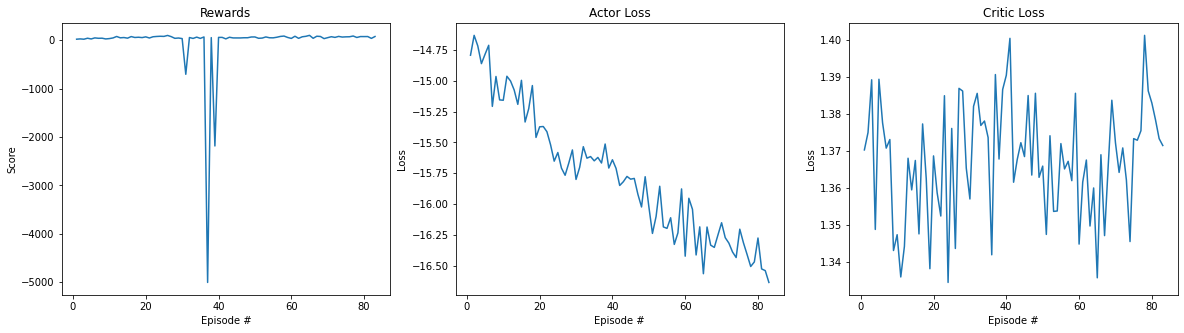

[21.392249278646585,
 27.379753038054332,
 21.034503325431917,
 41.557216068652146,
 26.421985853114165,
 48.294320264598355,
 40.15159878577106,
 41.878746138808005,
 26.655074794466298,
 33.913033388952805,
 47.26615075984349,
 77.57503569832382,
 49.99791725523149,
 55.563720170796536,
 42.83357865307092,
 75.52723336219788,
 56.859521000413224,
 61.81035288524193,
 54.54738890302057,
 69.70502418741428,
 46.21177799658229,
 71.77323369402438,
 77.91703991529842,
 81.96657711259711,
 79.26046366652008,
 99.0438322678674,
 74.23344600247219,
 39.31828343324984,
 45.808694343703486,
 34.06649763369933,
 -704.0449224435724,
 55.76487931531543,
 37.29085905535612,
 64.15796011379764,
 38.179736365253724,
 67.70979517954402,
 -5006.386923988524,
 54.37207316521866,
 -2185.64927950061,
 58.65009061122934,
 58.64673456805758,
 28.081393950308364,
 61.55739464960061,
 47.604471990605816,
 47.361187050817534,
 47.33616418368183,
 51.27619261286842,
 51.52394371503033,
 66.98106042885532,
 67

In [45]:
##################
# Achieved rewards @ eps~=400 in 300 episodes
##################
# Params Override: Initialized in params.py
params = Params()
params.random_seed = 0
params.n_episodes=3000
params.max_t = 1000
params.print_every = 20
params.save_every = 100
params.prefill_memory_qty=100000
params.terminate_on_target_score = True
params.plot_stats = True
params.lr_actor = 1e-5                  
params.lr_critic = 1e-4 
params.vmin = -1
params.vmax = 400
params.num_atoms = 100
params.hard_weights_update_every = 2000
params.buffer_size = int(1e6)
params.gamma = 0.95
params.batch_size = 512
params.restart_training = False

#### MAIN #####
logger = Logger(params)
agent = D4PG_Agent(state_size, action_size, params=params)
d4pg(params, logger)

### 4. Watch a Smart Agent!

In the next code cell, you will load the trained weights from file to watch a smart agent!

In [15]:
# load the weights from file
params = Params()
logger = Logger(params)
agent = D4PG_Agent(state_size, action_size, params=params)
agent.actor_local.load_state_dict(torch.load('weights/saved/checkpoint_actor_ep224.pth'))
agent.critic_local.load_state_dict(torch.load('weights/saved/checkpoint_critic_ep224.pth'))


env_info = env.reset(train_mode=False)[brain_name]     # reset the environment
states = env_info.vector_observations                # get the current state
score = 0                                              # initialize the score
while True:
    # Perform actions from each agent's policy network (clipped actions [0, -1])
    actions = [ agent.act(state, add_noise=False) for state in states ]  
    actions = np.stack(actions)      
    env_info = env.step(actions)[brain_name]  # send the action to the environment 
    next_states = env_info.vector_observations       # get the next state
    rewards = env_info.rewards                       # get the reward
    dones = env_info.local_done                      # see if episode has finished
    score += max(rewards)                                    # update the score
    states = next_states                                 # roll over the state to next time step
    if any(dones):                                           # exit loop if episode finished
        break
    
print("Score: {}".format(score))


=============== HYPERPARAMS ===============
DEVICE:  cuda:0
RANDOM SEED:  0
BUFFER_SIZE:  300000
BATCH_SIZE:  128
HIDDEN_SIZES:  (256, 128)
GAMMA:  0.99
TAU:  0.001
LR_ACTOR:  0.0005
LR_CRITIC:  0.001
WEIGHT_DECAY:  0.0001
HARD_UPDATE:  True
LEARN_EVERY:  1
HARD_WEIGHTS_UPDATE_EVERY:  350
N_STEP_BOOTSTRAP:  5
VMIN:  -0.01
VMAX:  20
NUM_ATOMS:  100

Score: 16.966790332458913


When finished, you can close the environment.

In [ ]:
# env.close()